In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import json

warnings.filterwarnings("ignore")

# Set up professional plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12

%matplotlib inline

# Create output directory for plots
output_dir = Path("../forecast_plots")
output_dir.mkdir(exist_ok=True)
print(f"Output directory created: {output_dir.absolute()}")


/Users/edonisalijaj/Downloads/patient-segmentation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Output directory created: /Users/edonisalijaj/Downloads/patient-segmentation/tsfdc/notebooks/../forecast_plots


In [2]:
# Load data
df = pd.read_csv("../data/atc3_monthly_full.csv")
df['month_start'] = pd.to_datetime(df['month_start'])

print("Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Date range: {df['month_start'].min()} to {df['month_start'].max()}")
print(f"Number of ATC3 codes: {df['atc3_code'].nunique()}")

# Get top ATC3 codes by total consumption for forecasting
top_codes = df.groupby('atc3_code')['packages'].sum().sort_values(ascending=False).head(10).index.tolist()
print(f"\nTop 10 ATC3 codes for forecasting: {top_codes}")


Data loaded successfully!
Shape: (1176, 10)
Date range: 2023-05-01 00:00:00 to 2025-01-01 00:00:00
Number of ATC3 codes: 56

Top 10 ATC3 codes for forecasting: ['C09B', 'A02B', 'C07A', 'M01A', 'N05B', 'B01A', 'C10A', 'C09A', 'A10B', 'N02A']


In [3]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100  # +1 to avoid division by zero
    r2 = r2_score(y_true, y_pred)
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

def plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, 
                             train_dates, test_dates, model_name, atc3_code, save_path):
    """Plot actual vs predicted for train and test sets"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Training: Time series
    axes[0, 0].plot(train_dates, y_train, label='Actual', linewidth=2, color='#2E86AB')
    axes[0, 0].plot(train_dates, y_train_pred, label='Predicted', linewidth=2, 
                   linestyle='--', color='#A23B72', alpha=0.8)
    axes[0, 0].set_title(f'{model_name} - Training Set (Time Series)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Date', fontsize=10)
    axes[0, 0].set_ylabel('Packages', fontsize=10)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Training: Scatter
    axes[0, 1].scatter(y_train, y_train_pred, alpha=0.5, s=30, color='#2E86AB')
    min_val = min(y_train.min(), y_train_pred.min())
    max_val = max(y_train.max(), y_train_pred.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    axes[0, 1].set_title(f'{model_name} - Training Set (Scatter)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Actual', fontsize=10)
    axes[0, 1].set_ylabel('Predicted', fontsize=10)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Test: Time series
    axes[1, 0].plot(test_dates, y_test, label='Actual', linewidth=2, color='#2E86AB')
    axes[1, 0].plot(test_dates, y_test_pred, label='Predicted', linewidth=2, 
                   linestyle='--', color='#A23B72', alpha=0.8)
    axes[1, 0].set_title(f'{model_name} - Test Set (Time Series)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Date', fontsize=10)
    axes[1, 0].set_ylabel('Packages', fontsize=10)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Test: Scatter
    axes[1, 1].scatter(y_test, y_test_pred, alpha=0.5, s=30, color='#A23B72')
    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    axes[1, 1].set_title(f'{model_name} - Test Set (Scatter)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Actual', fontsize=10)
    axes[1, 1].set_ylabel('Predicted', fontsize=10)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name} - Actual vs Predicted: {atc3_code}', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

def plot_residuals(y_train, y_train_pred, y_test, y_test_pred, 
                   train_dates, test_dates, model_name, atc3_code, save_path):
    """Plot residual analysis"""
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Training residuals over time
    axes[0, 0].scatter(train_dates, train_residuals, alpha=0.5, s=30, color='#2E86AB')
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_title(f'{model_name} - Training Residuals (Time Series)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Date', fontsize=10)
    axes[0, 0].set_ylabel('Residuals', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Training residuals distribution
    axes[0, 1].hist(train_residuals, bins=30, edgecolor='black', alpha=0.7, color='#2E86AB')
    axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_title(f'{model_name} - Training Residuals Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Residuals', fontsize=10)
    axes[0, 1].set_ylabel('Frequency', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Test residuals over time
    axes[1, 0].scatter(test_dates, test_residuals, alpha=0.5, s=30, color='#A23B72')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_title(f'{model_name} - Test Residuals (Time Series)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Date', fontsize=10)
    axes[1, 0].set_ylabel('Residuals', fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Test residuals distribution
    axes[1, 1].hist(test_residuals, bins=30, edgecolor='black', alpha=0.7, color='#A23B72')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_title(f'{model_name} - Test Residuals Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Residuals', fontsize=10)
    axes[1, 1].set_ylabel('Frequency', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'{model_name} - Residual Analysis: {atc3_code}', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

print("Helper functions defined!")


Helper functions defined!


In [4]:
# ============================================================================
# PREPARE DATA FOR FORECASTING
# ============================================================================

# Focus on top ATC3 code for detailed analysis (can be extended to all)
target_atc3 = top_codes[0]
print(f"Forecasting for ATC3 code: {target_atc3}")

# Filter data for target ATC3 code
data = df[df['atc3_code'] == target_atc3].copy()
data = data.sort_values('month_start').reset_index(drop=True)

print(f"\nData shape: {data.shape}")
print(f"Date range: {data['month_start'].min()} to {data['month_start'].max()}")

# Train/Test split: Use last 3 months for testing (or 20% if less than 12 months)
n_test = max(3, int(len(data) * 0.2))
train_data = data.iloc[:-n_test].copy()
test_data = data.iloc[-n_test:].copy()

print(f"\nTrain size: {len(train_data)} months")
print(f"Test size: {len(test_data)} months")
print(f"Train period: {train_data['month_start'].min()} to {train_data['month_start'].max()}")
print(f"Test period: {test_data['month_start'].min()} to {test_data['month_start'].max()}")

# Prepare features
feature_cols = ['month', 'year', 'month_index', 'packages_lag1', 'packages_lag2', 'packages_lag3']
X_train = train_data[feature_cols].values
y_train = train_data['packages'].values
X_test = test_data[feature_cols].values
y_test = test_data['packages'].values

train_dates = train_data['month_start'].values
test_dates = test_data['month_start'].values

print(f"\nFeatures used: {feature_cols}")

# Note: We'll use log1p transformation for XGBoost and Prophet
# Benefits:
# 1. Handles skewed/non-negative data better
# 2. Prevents negative predictions
# 3. Reduces impact of outliers
# 4. Better for count-like data (drug consumption)
# Predictions will be back-transformed using expm1 for evaluation


Forecasting for ATC3 code: C09B

Data shape: (21, 10)
Date range: 2023-05-01 00:00:00 to 2025-01-01 00:00:00

Train size: 17 months
Test size: 4 months
Train period: 2023-05-01 00:00:00 to 2024-09-01 00:00:00
Test period: 2024-10-01 00:00:00 to 2025-01-01 00:00:00

Features used: ['month', 'year', 'month_index', 'packages_lag1', 'packages_lag2', 'packages_lag3']


MODEL 1: XGBOOST (with log1p transformation)

Training Metrics:
  MAE: 0.0859
  RMSE: 0.1142
  MAPE: 0.1249
  R2: 1.0000

Test Metrics:
  MAE: 28.5226
  RMSE: 41.4980
  MAPE: 231.2708
  R2: -1.1607


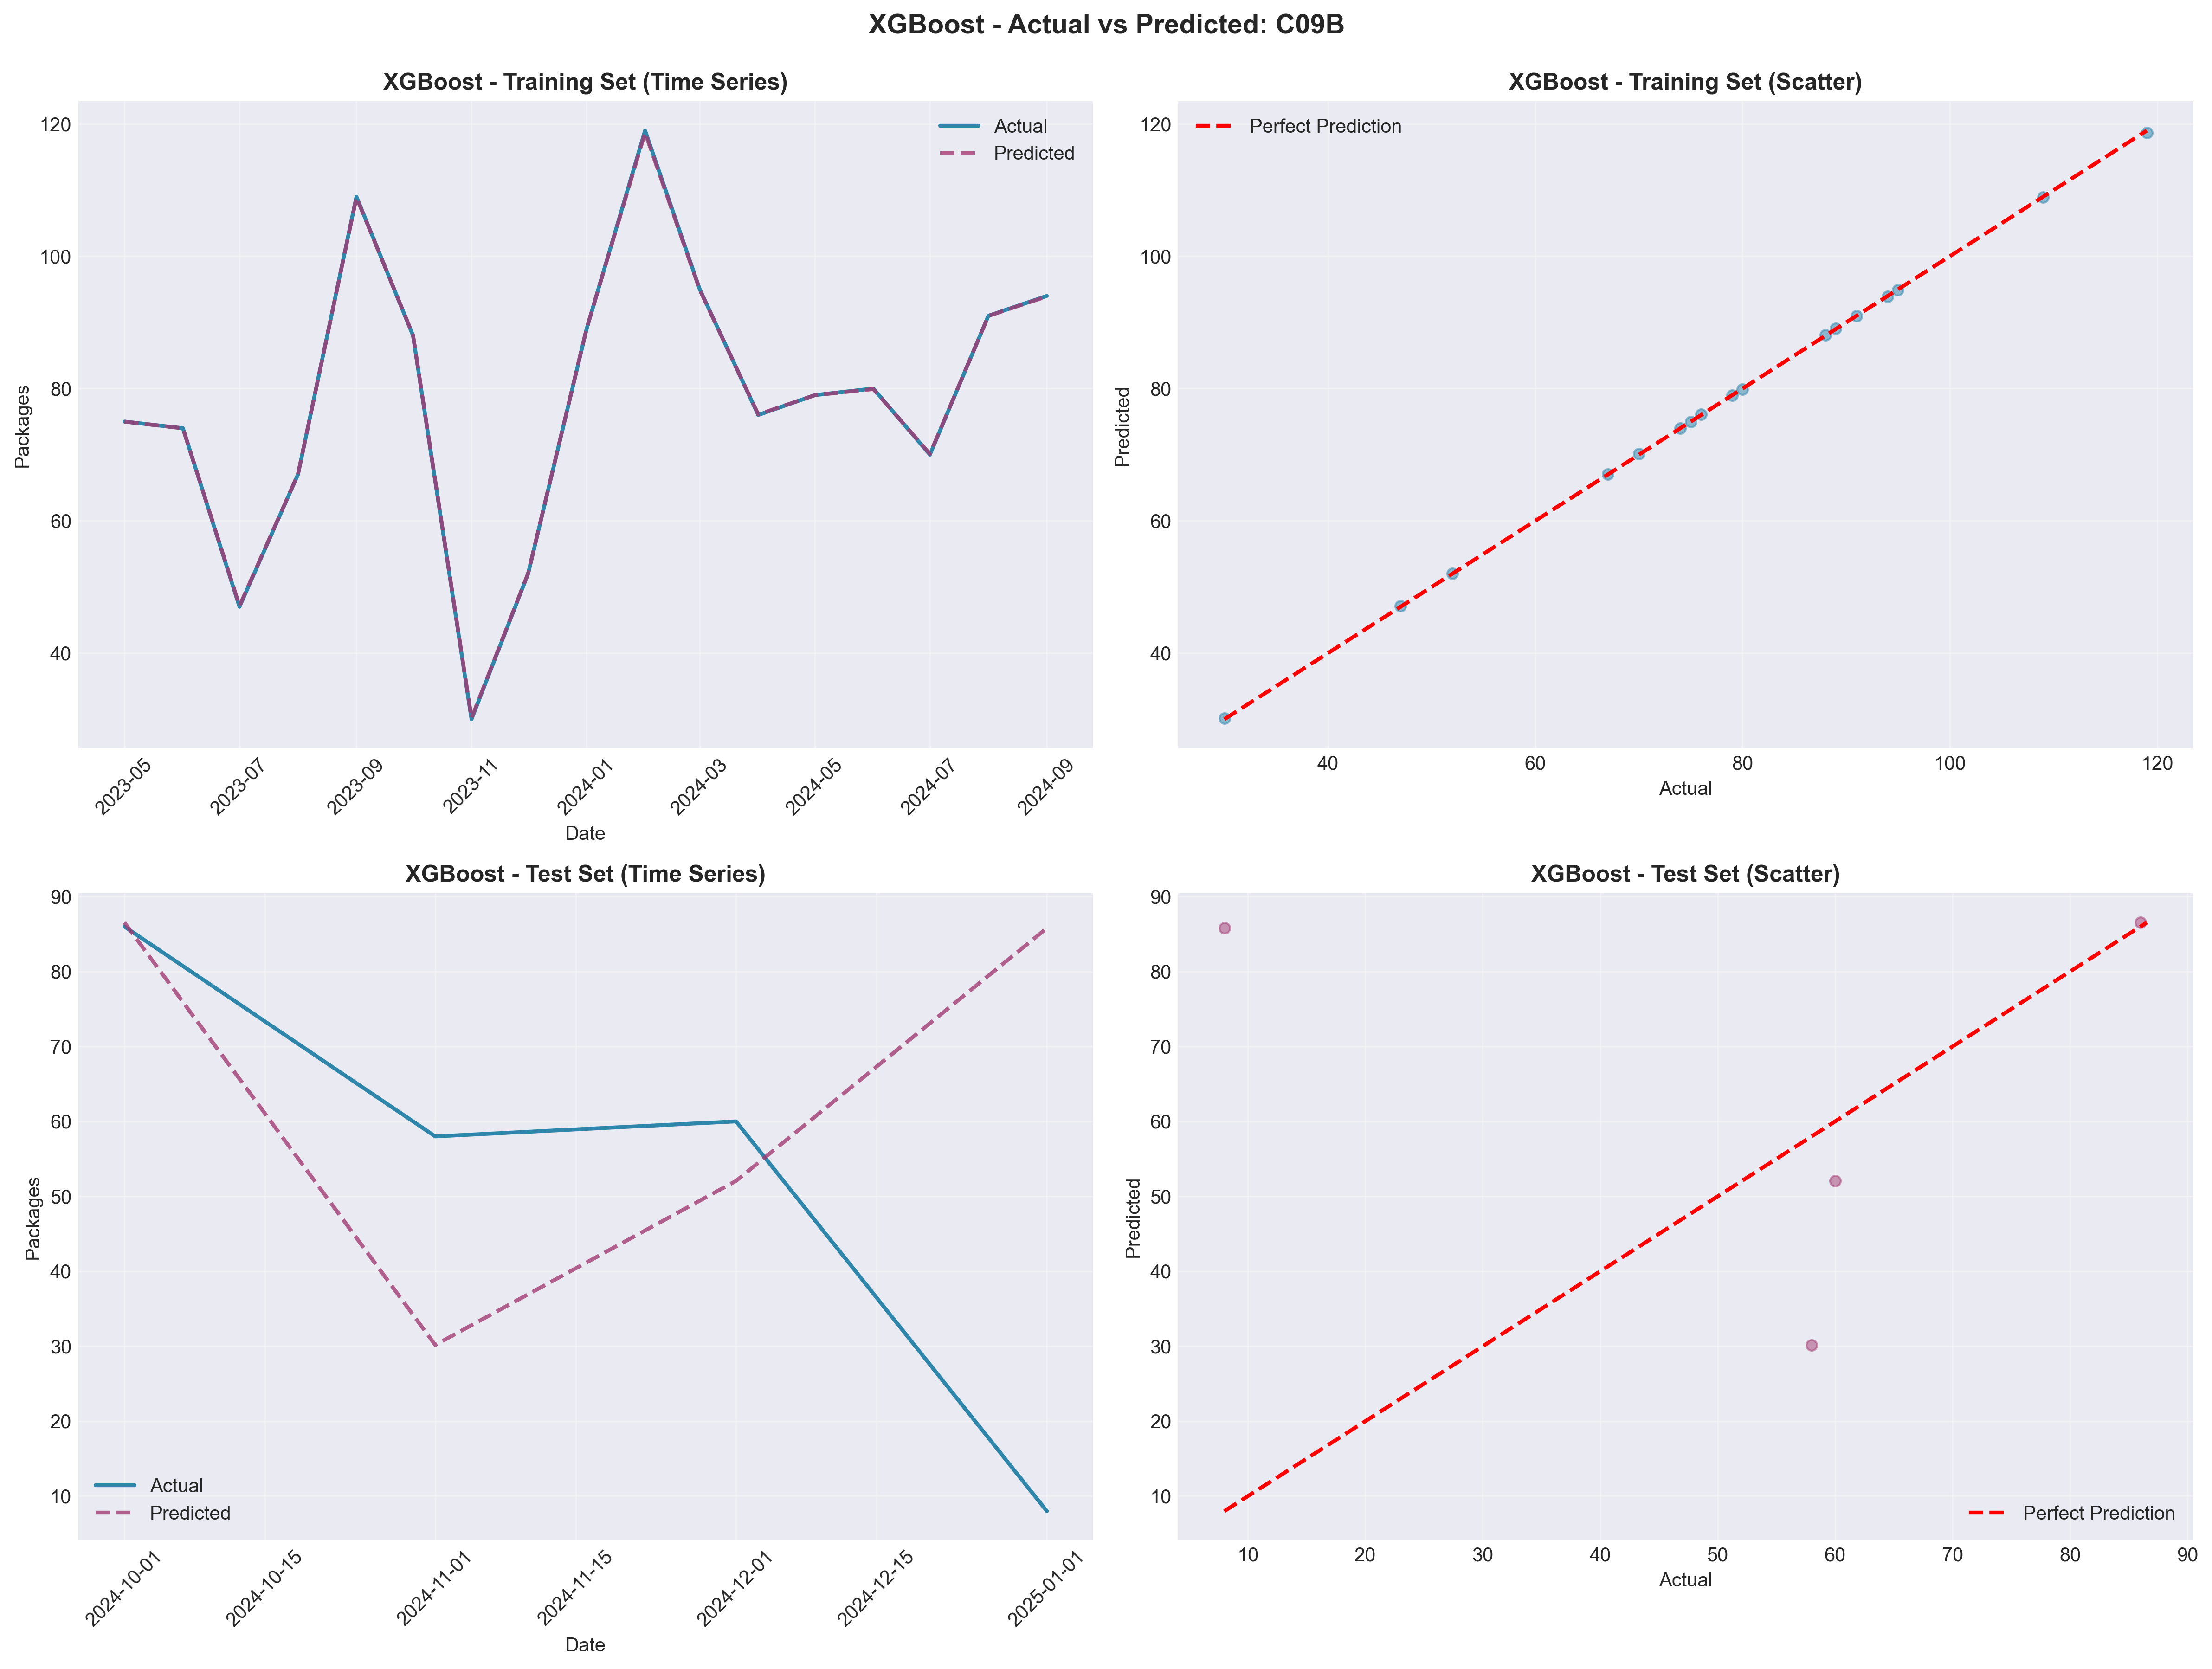

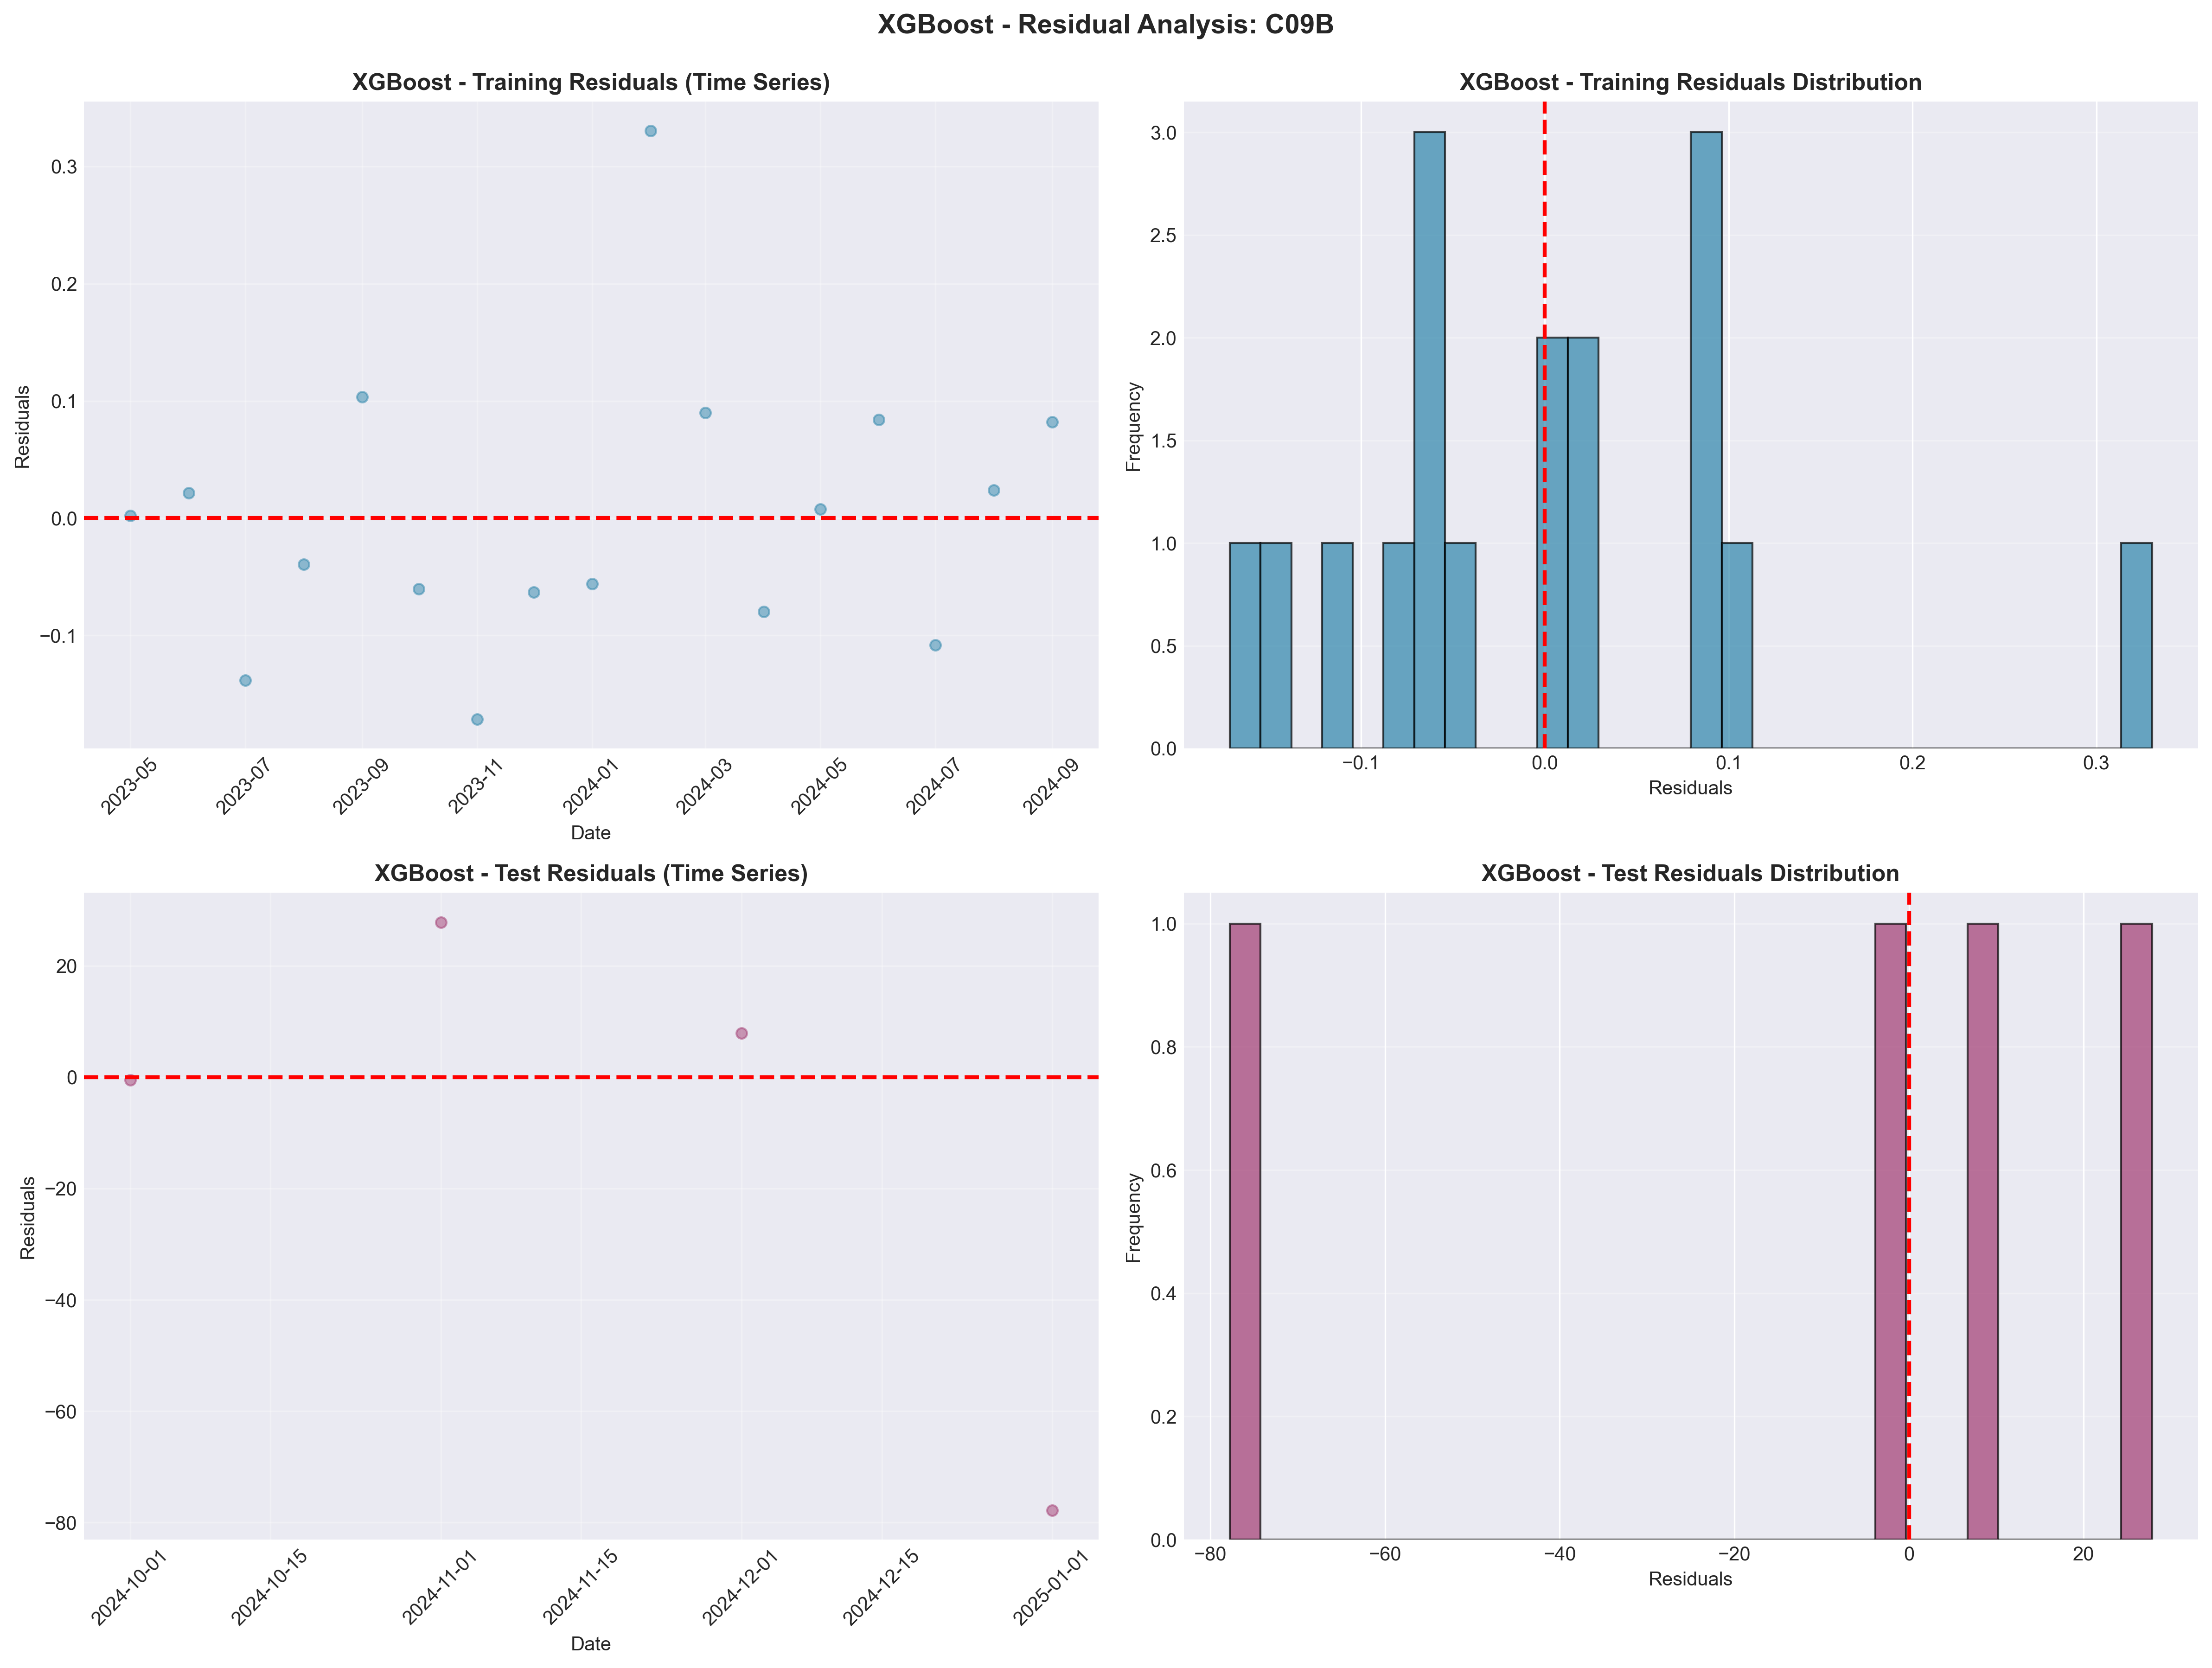

In [5]:
# ============================================================================
# MODEL 1: XGBOOST (with log1p transformation)
# ============================================================================

print("=" * 80)
print("MODEL 1: XGBOOST (with log1p transformation)")
print("=" * 80)

# Transform target to log space for better handling of skewed data
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train XGBoost on log-transformed target
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train_log)

# Predictions (in log space)
y_train_pred_xgb_log = xgb_model.predict(X_train)
y_test_pred_xgb_log = xgb_model.predict(X_test)

# Back-transform predictions to original scale
y_train_pred_xgb = np.expm1(y_train_pred_xgb_log)
y_test_pred_xgb = np.expm1(y_test_pred_xgb_log)

# Metrics (on original scale)
train_metrics_xgb = calculate_metrics(y_train, y_train_pred_xgb)
test_metrics_xgb = calculate_metrics(y_test, y_test_pred_xgb)

print("\nTraining Metrics:")
for metric, value in train_metrics_xgb.items():
    print(f"  {metric}: {value:.4f}")

print("\nTest Metrics:")
for metric, value in test_metrics_xgb.items():
    print(f"  {metric}: {value:.4f}")

# Visualizations
plot_actual_vs_predicted(
    y_train, y_train_pred_xgb, y_test, y_test_pred_xgb,
    train_dates, test_dates, 'XGBoost', target_atc3,
    output_dir / f'xgb_actual_vs_predicted_{target_atc3}.png'
)

plot_residuals(
    y_train, y_train_pred_xgb, y_test, y_test_pred_xgb,
    train_dates, test_dates, 'XGBoost', target_atc3,
    output_dir / f'xgb_residuals_{target_atc3}.png'
)



MODEL 2: SARIMA
Training data length: 17 months
Using SARIMA with simpler seasonal component (12-23 months)

Training Metrics:
  MAE: 26.9229
  RMSE: 32.5008
  MAPE: 41.1226
  R2: -1.3224

Test Metrics:
  MAE: 26.6174
  RMSE: 33.1880
  MAPE: 178.4012
  R2: -0.3820

SARIMA Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                          packages   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 8)   Log Likelihood                   0.000
Date:                           Fri, 21 Nov 2025   AIC                              8.000
Time:                                   08:20:11   BIC                                nan
Sample:                               05-01-2023   HQIC                               nan
                                    - 09-01-2024                                         
Covariance Type:                             opg                                 

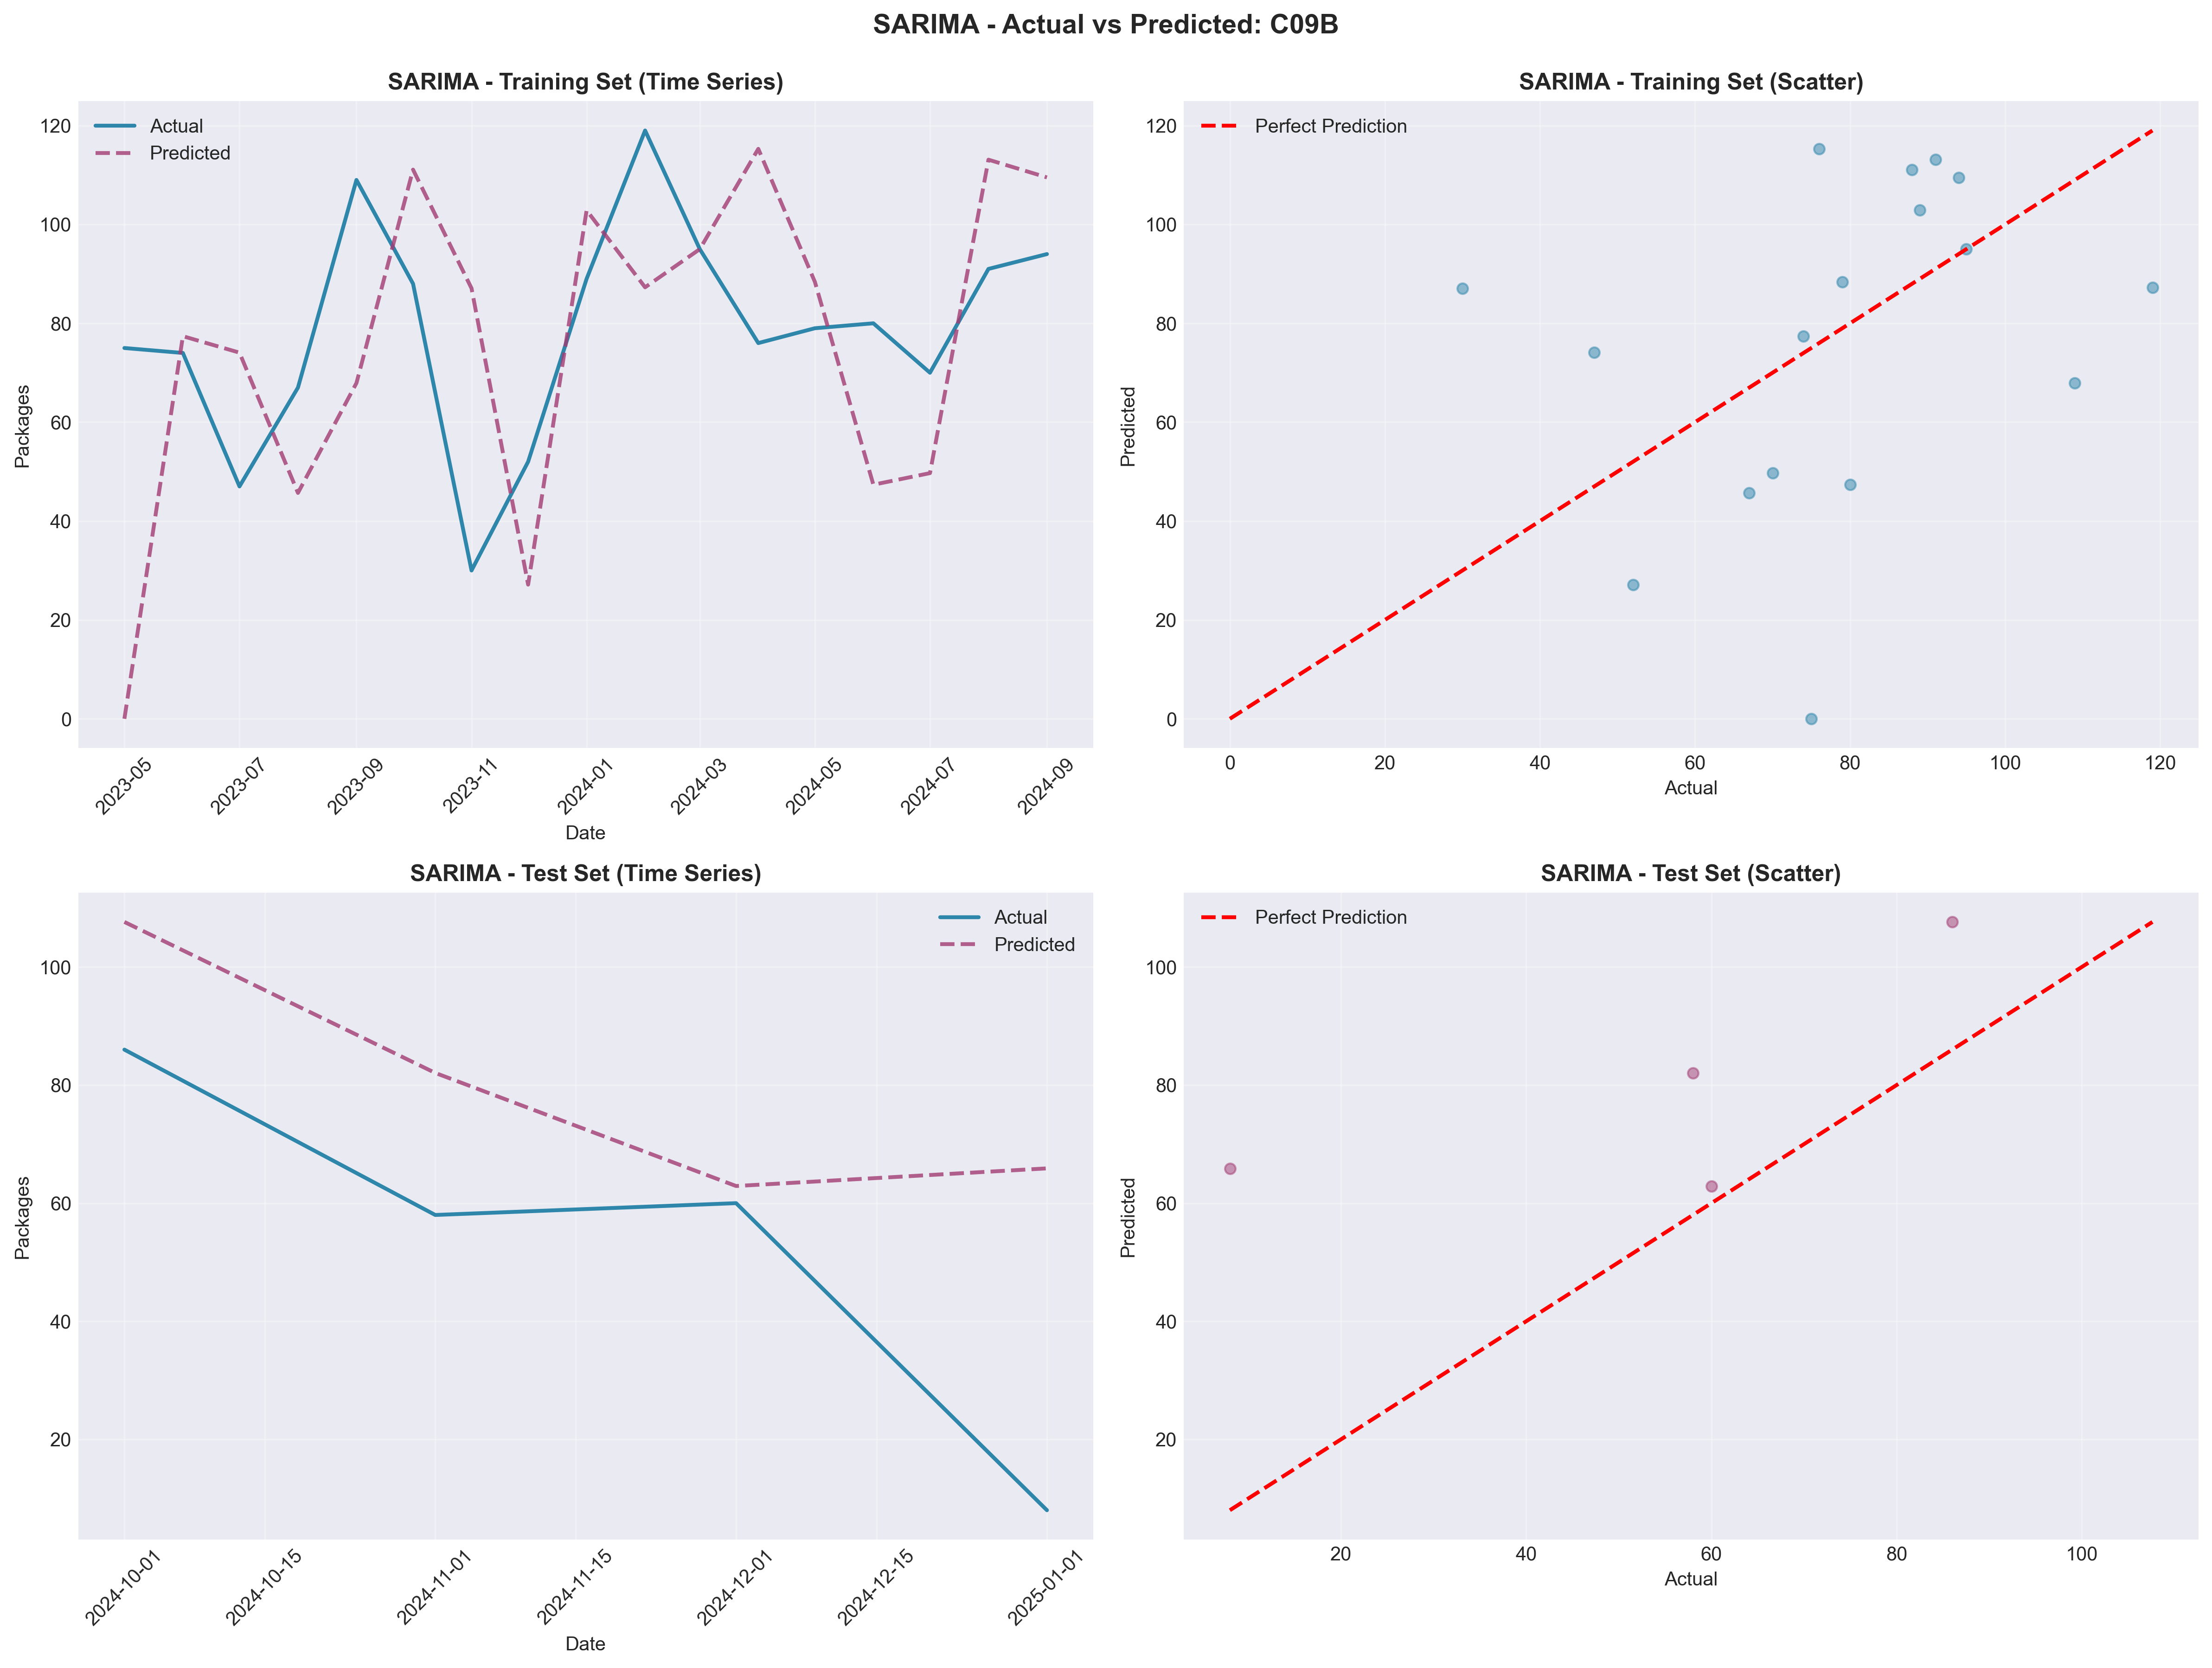

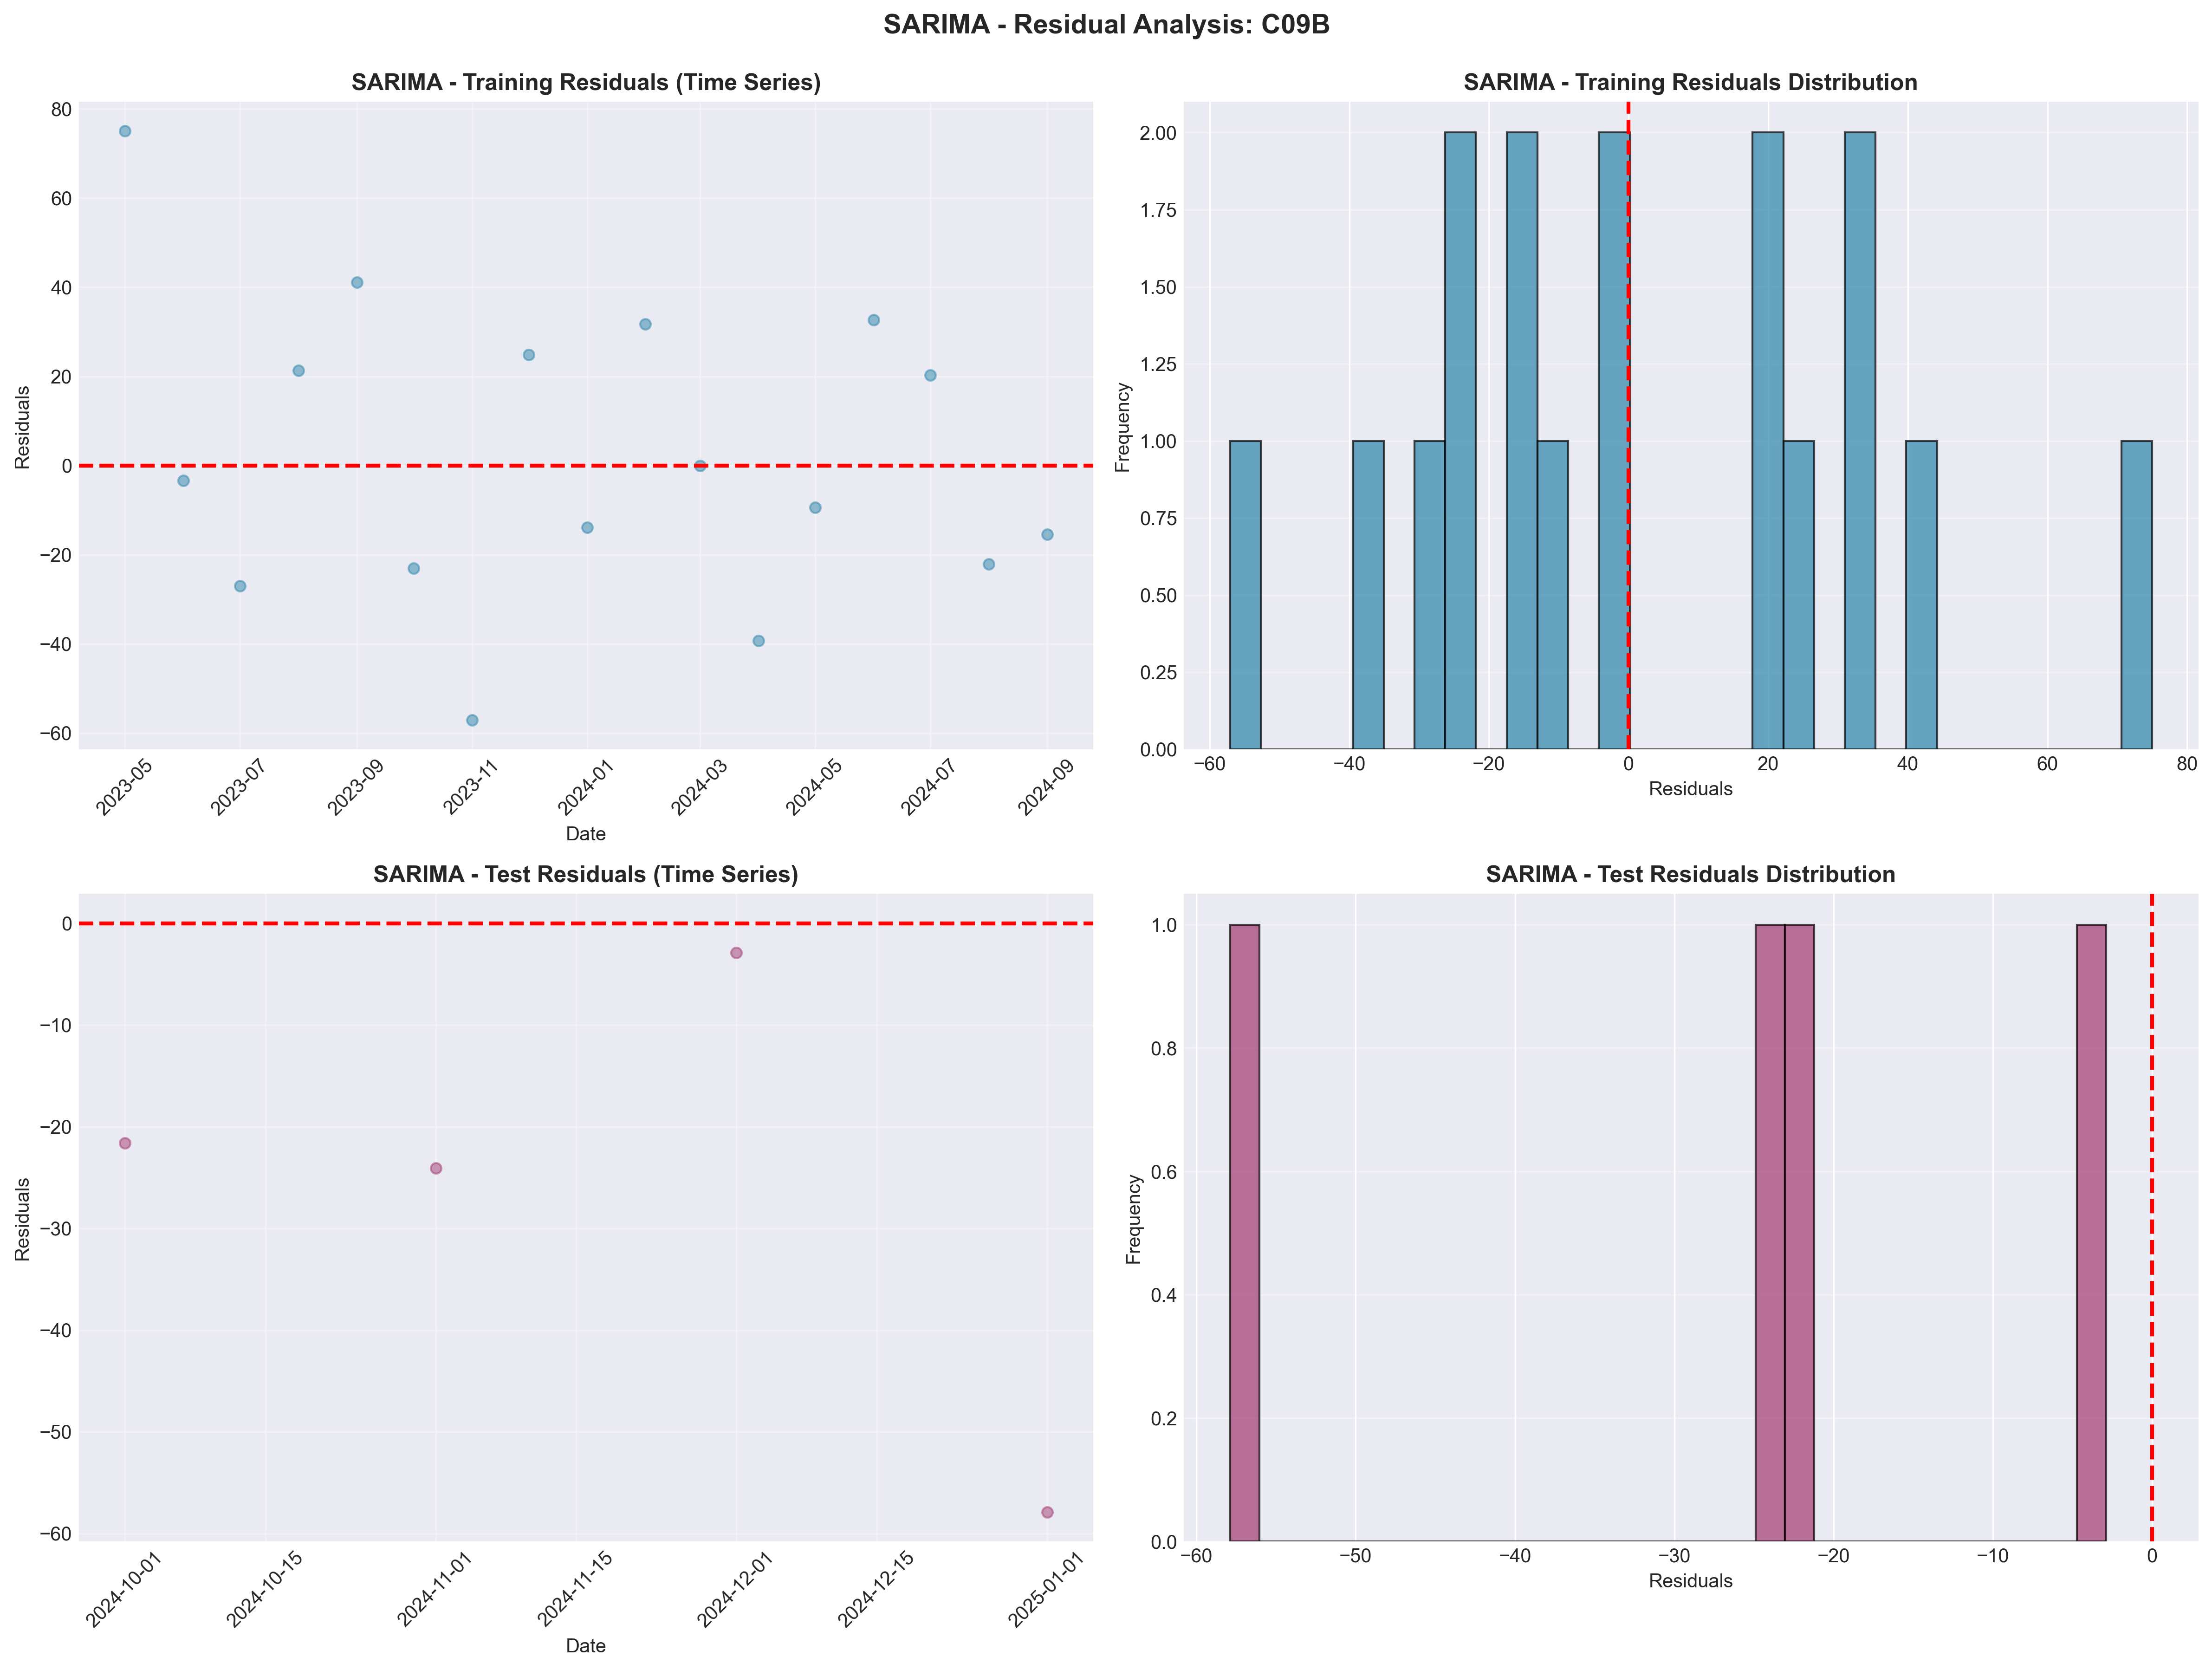

In [6]:
# ============================================================================
# MODEL 2: SARIMA (fixed - adaptive order selection based on data length)
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 2: SARIMA")
print("=" * 80)

# Prepare time series for SARIMA
train_ts = train_data.set_index('month_start')['packages']
test_ts = test_data.set_index('month_start')['packages']

# Determine appropriate model based on data length
n_train = len(train_ts)
print(f"Training data length: {n_train} months")

# Fit SARIMA model with adaptive order selection
try:
    if n_train >= 24:
        # Enough data for seasonal component (need at least 2 years)
        print("Using SARIMA with seasonal component (>= 24 months)")
        sarima_model = SARIMAX(
            train_ts,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
    elif n_train >= 12:
        # Enough for seasonal but simpler order
        print("Using SARIMA with simpler seasonal component (12-23 months)")
        sarima_model = SARIMAX(
            train_ts,
            order=(1, 1, 1),
            seasonal_order=(0, 1, 1, min(12, n_train // 2)),  # Reduced seasonal order
            enforce_stationarity=False,
            enforce_invertibility=False
        )
    else:
        # Not enough data for seasonal, use ARIMA
        print("Using ARIMA (no seasonal component, < 12 months)")
        sarima_model = SARIMAX(
            train_ts,
            order=(1, 1, 1),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
    
    sarima_fitted = sarima_model.fit(disp=False, maxiter=200)
    
    # Predictions
    y_train_pred_sarima = sarima_fitted.fittedvalues.values
    y_test_pred_sarima = sarima_fitted.forecast(steps=len(test_ts)).values
    
    # Clip negative predictions to 0
    y_train_pred_sarima = np.maximum(y_train_pred_sarima, 0)
    y_test_pred_sarima = np.maximum(y_test_pred_sarima, 0)
    
    # Cap extreme predictions (more than 10x the max observed value)
    max_observed = max(train_ts.max(), test_ts.max())
    y_train_pred_sarima = np.minimum(y_train_pred_sarima, max_observed * 10)
    y_test_pred_sarima = np.minimum(y_test_pred_sarima, max_observed * 10)
    
    # Metrics
    train_metrics_sarima = calculate_metrics(y_train, y_train_pred_sarima)
    test_metrics_sarima = calculate_metrics(y_test, y_test_pred_sarima)
    
    print("\nTraining Metrics:")
    for metric, value in train_metrics_sarima.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nTest Metrics:")
    for metric, value in test_metrics_sarima.items():
        print(f"  {metric}: {value:.4f}")
    
    print(f"\nSARIMA Model Summary:")
    print(sarima_fitted.summary().tables[0])
    
    # Visualizations
    plot_actual_vs_predicted(
        y_train, y_train_pred_sarima, y_test, y_test_pred_sarima,
        train_dates, test_dates, 'SARIMA', target_atc3,
        output_dir / f'sarima_actual_vs_predicted_{target_atc3}.png'
    )
    
    plot_residuals(
        y_train, y_train_pred_sarima, y_test, y_test_pred_sarima,
        train_dates, test_dates, 'SARIMA', target_atc3,
        output_dir / f'sarima_residuals_{target_atc3}.png'
    )
    
except Exception as e:
    print(f"Error fitting SARIMA: {e}")
    print("Trying simpler ARIMA model...")
    
    # Fallback to ARIMA
    try:
        arima_model = ARIMA(train_ts, order=(1, 1, 1))
        arima_fitted = arima_model.fit()
        
        y_train_pred_sarima = arima_fitted.fittedvalues.values
        y_test_pred_sarima = arima_fitted.forecast(steps=len(test_ts)).values
        
        train_metrics_sarima = calculate_metrics(y_train, y_train_pred_sarima)
        test_metrics_sarima = calculate_metrics(y_test, y_test_pred_sarima)
        
        print("\nTraining Metrics (ARIMA):")
        for metric, value in train_metrics_sarima.items():
            print(f"  {metric}: {value:.4f}")
        
        print("\nTest Metrics (ARIMA):")
        for metric, value in test_metrics_sarima.items():
            print(f"  {metric}: {value:.4f}")
        
        plot_actual_vs_predicted(
            y_train, y_train_pred_sarima, y_test, y_test_pred_sarima,
            train_dates, test_dates, 'ARIMA', target_atc3,
            output_dir / f'arima_actual_vs_predicted_{target_atc3}.png'
        )
        
        plot_residuals(
            y_train, y_train_pred_sarima, y_test, y_test_pred_sarima,
            train_dates, test_dates, 'ARIMA', target_atc3,
            output_dir / f'arima_residuals_{target_atc3}.png'
        )
        
    except Exception as e2:
        print(f"Error fitting ARIMA: {e2}")
        y_train_pred_sarima = None
        y_test_pred_sarima = None
        train_metrics_sarima = None
        test_metrics_sarima = None


08:20:14 - cmdstanpy - INFO - Chain [1] start processing
08:20:14 - cmdstanpy - INFO - Chain [1] done processing



MODEL 3: PROPHET

Training Metrics:
  MAE: 15.5593
  RMSE: 20.4043
  MAPE: 25.0684
  R2: 0.0846

Test Metrics:
  MAE: 38.8365
  RMSE: 48.7974
  MAPE: 266.6915
  R2: -1.9877


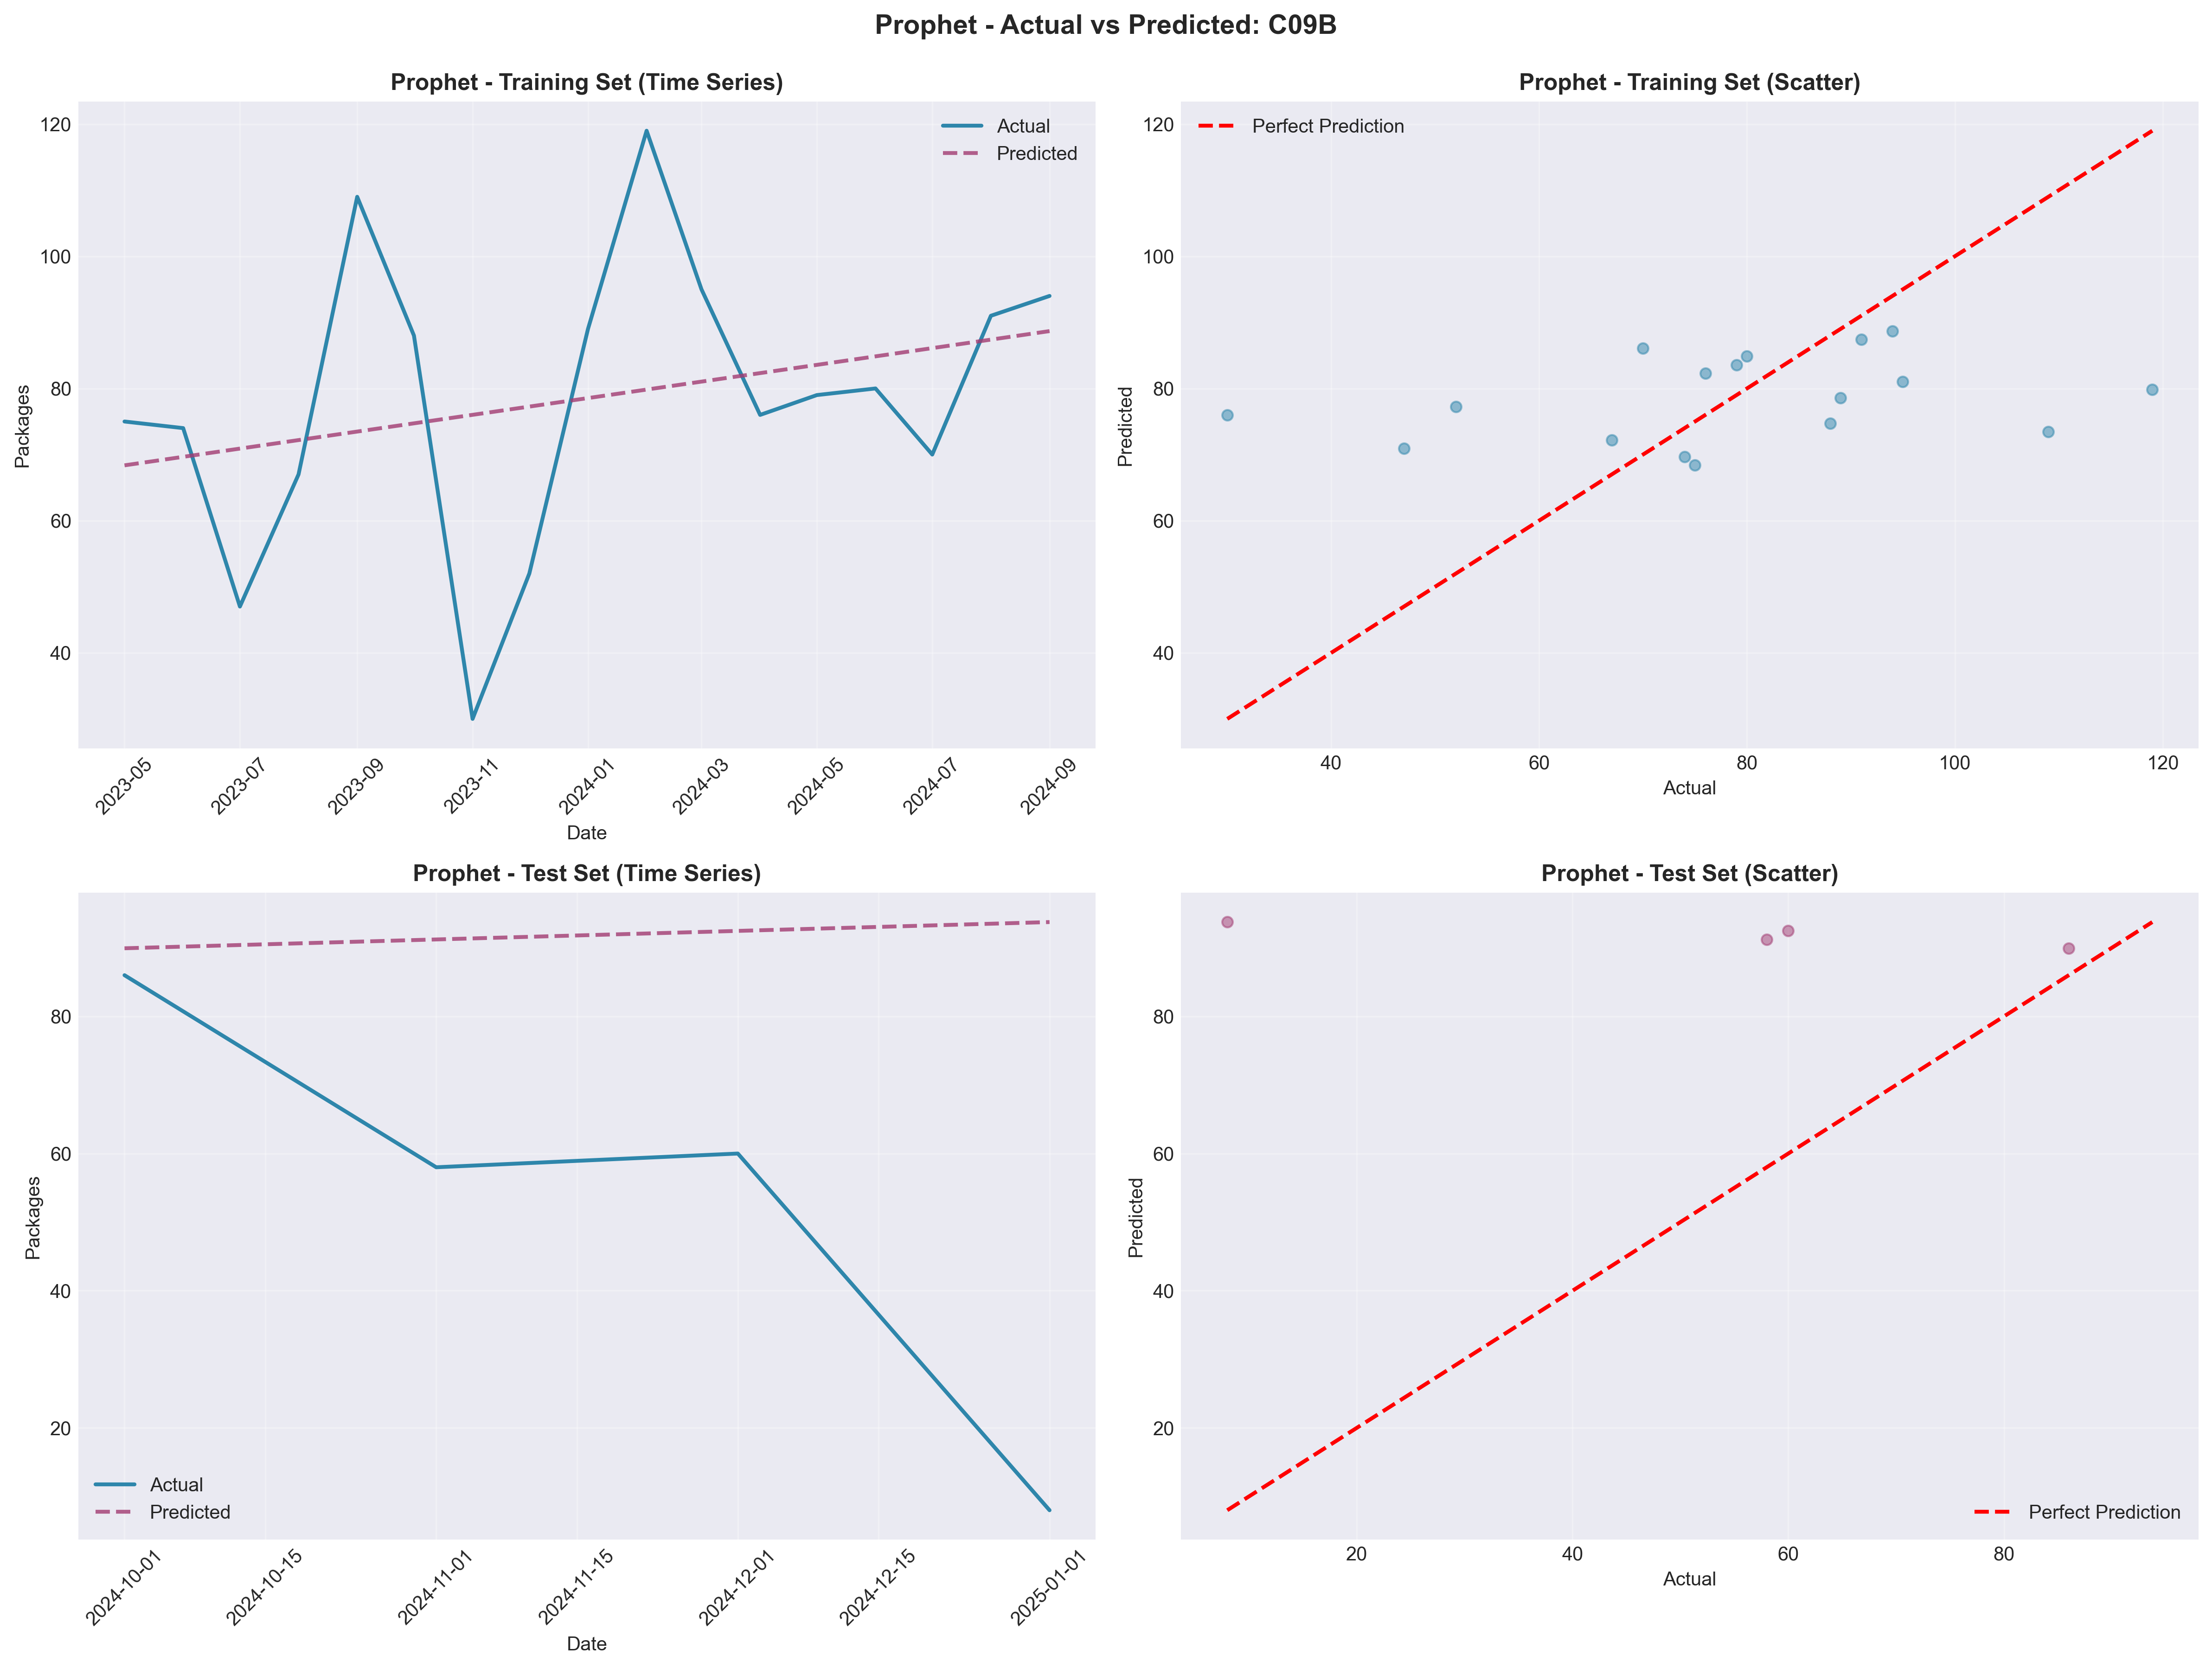

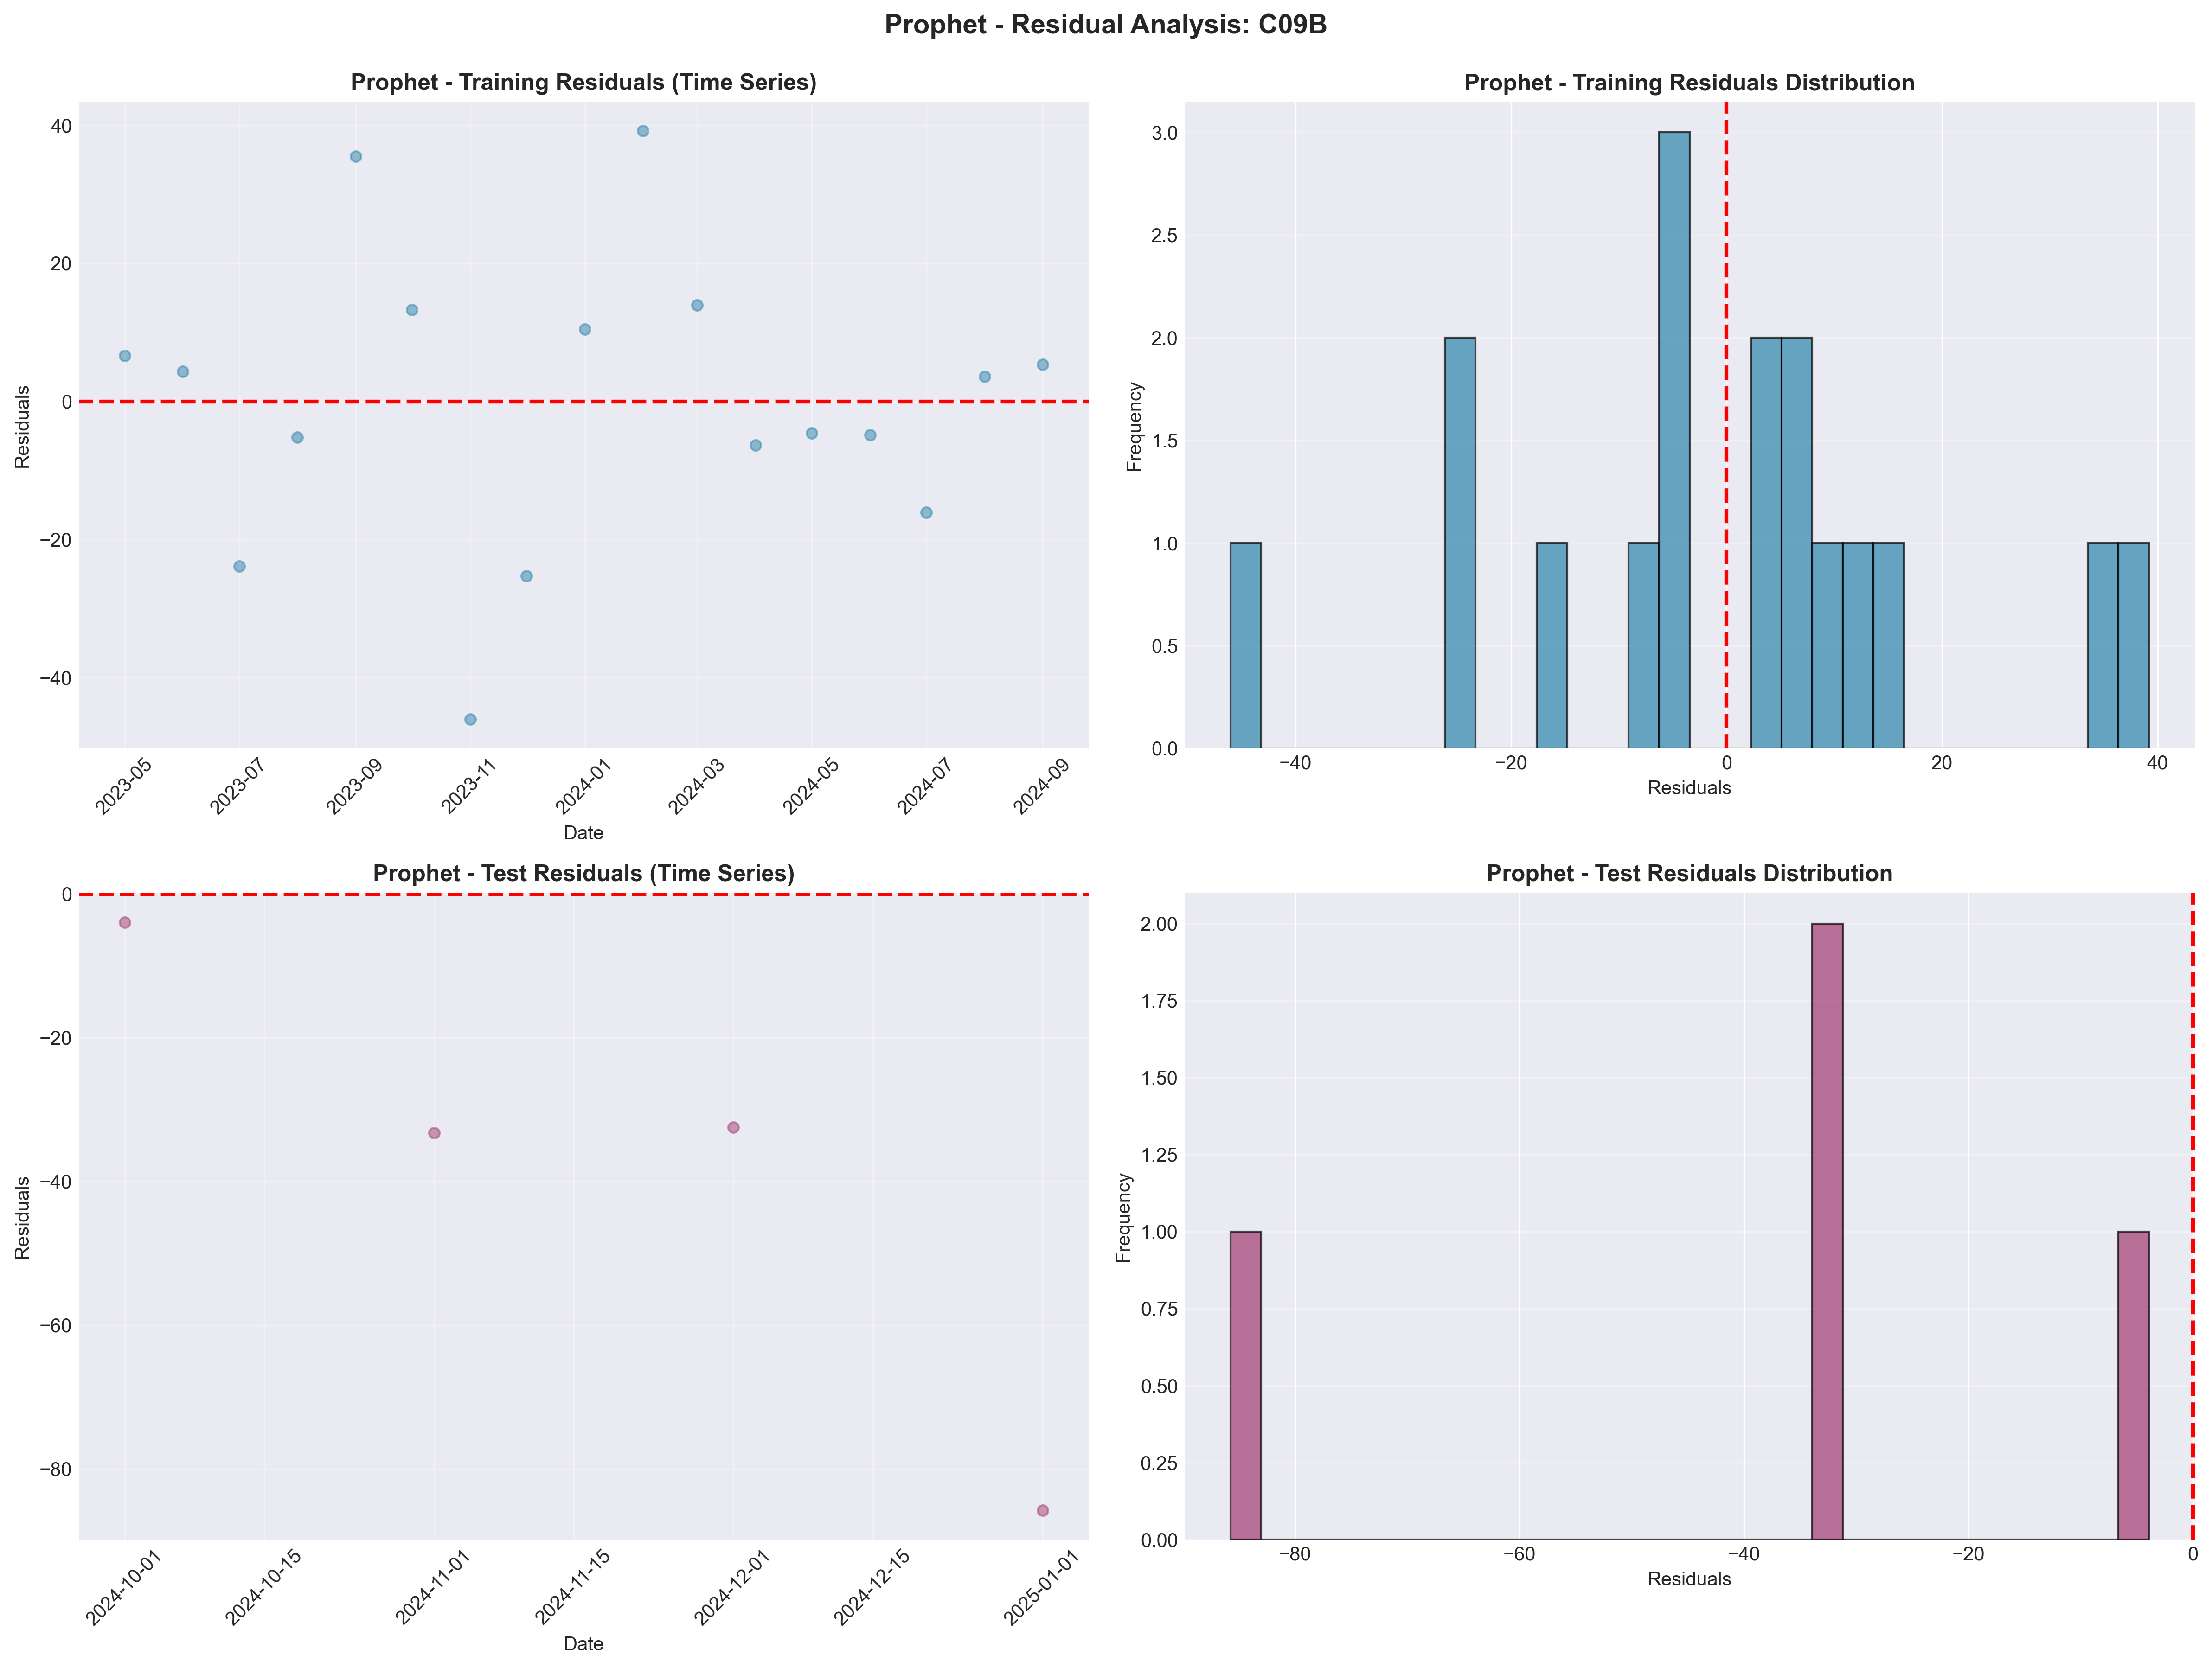

In [7]:
# ============================================================================
# MODEL 3: PROPHET (fixed - using additive seasonality on original scale)
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 3: PROPHET")
print("=" * 80)

# Prepare data for Prophet (use original scale, not log-transformed)
# Prophet handles non-negative data well on its own
prophet_train = pd.DataFrame({
    'ds': train_data['month_start'],
    'y': train_data['packages']  # Use original scale
})

prophet_test = pd.DataFrame({
    'ds': test_data['month_start'],
    'y': test_data['packages']
})

# Fit Prophet model with constraints to prevent extreme predictions
prophet_model = Prophet(
    yearly_seasonality=True if len(train_data) >= 24 else False,  # Only if enough data
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',  # Additive is more stable
    growth='linear',  # Linear growth instead of logistic
    interval_width=0.95
)

# Add changepoint prior scale to reduce sensitivity
prophet_model.changepoint_prior_scale = 0.05  # Lower = less flexible, more stable

prophet_model.fit(prophet_train)

# Predictions
prophet_train_forecast = prophet_model.predict(prophet_train[['ds']])
prophet_test_forecast = prophet_model.predict(prophet_test[['ds']])

y_train_pred_prophet = prophet_train_forecast['yhat'].values
y_test_pred_prophet = prophet_test_forecast['yhat'].values

# Clip negative predictions to 0 (drug consumption can't be negative)
y_train_pred_prophet = np.maximum(y_train_pred_prophet, 0)
y_test_pred_prophet = np.maximum(y_test_pred_prophet, 0)

# Cap extreme predictions (more than 10x the max observed value)
max_observed = max(train_data['packages'].max(), test_data['packages'].max())
y_train_pred_prophet = np.minimum(y_train_pred_prophet, max_observed * 10)
y_test_pred_prophet = np.minimum(y_test_pred_prophet, max_observed * 10)

# Metrics
train_metrics_prophet = calculate_metrics(y_train, y_train_pred_prophet)
test_metrics_prophet = calculate_metrics(y_test, y_test_pred_prophet)

print("\nTraining Metrics:")
for metric, value in train_metrics_prophet.items():
    print(f"  {metric}: {value:.4f}")

print("\nTest Metrics:")
for metric, value in test_metrics_prophet.items():
    print(f"  {metric}: {value:.4f}")

# Visualizations
plot_actual_vs_predicted(
    y_train, y_train_pred_prophet, y_test, y_test_pred_prophet,
    train_dates, test_dates, 'Prophet', target_atc3,
    output_dir / f'prophet_actual_vs_predicted_{target_atc3}.png'
)

plot_residuals(
    y_train, y_train_pred_prophet, y_test, y_test_pred_prophet,
    train_dates, test_dates, 'Prophet', target_atc3,
    output_dir / f'prophet_residuals_{target_atc3}.png'
)



MODEL 4: RANDOM FOREST

Training Metrics:
  MAE: 5.3276
  RMSE: 6.9473
  MAPE: 8.7670
  R2: 0.8939

Test Metrics:
  MAE: 24.4125
  RMSE: 42.8822
  MAPE: 242.1606
  R2: -1.3073


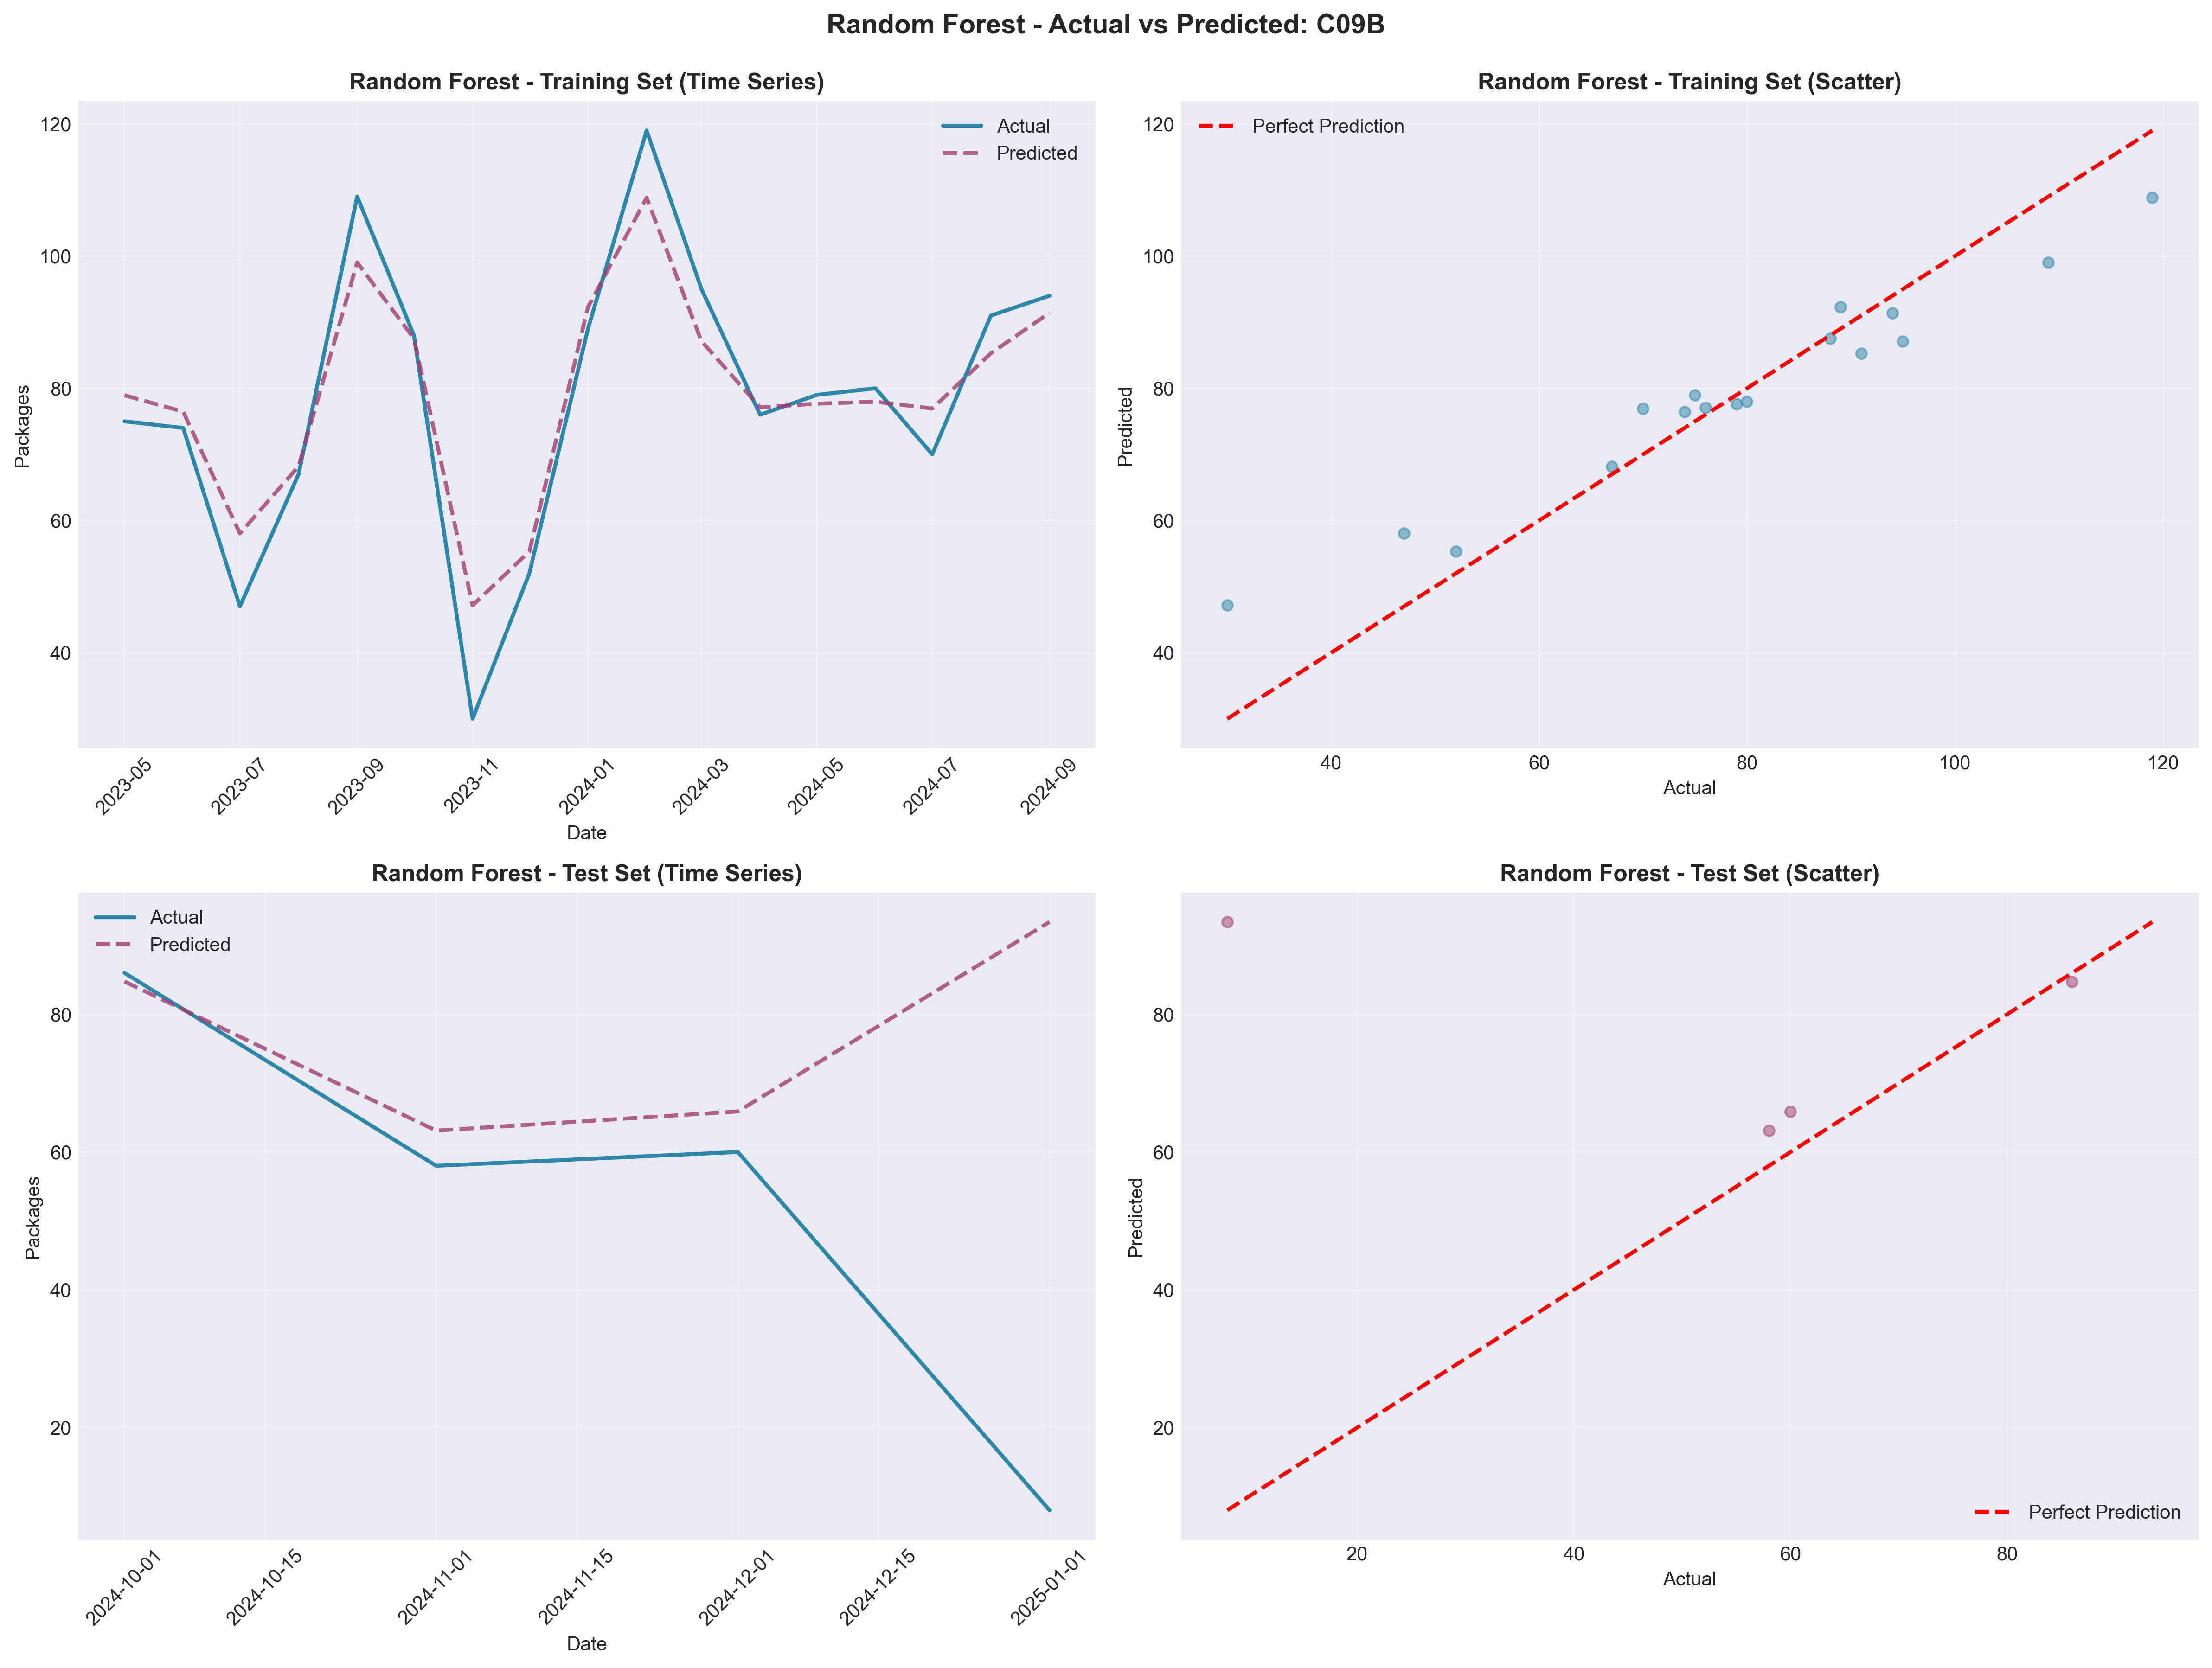

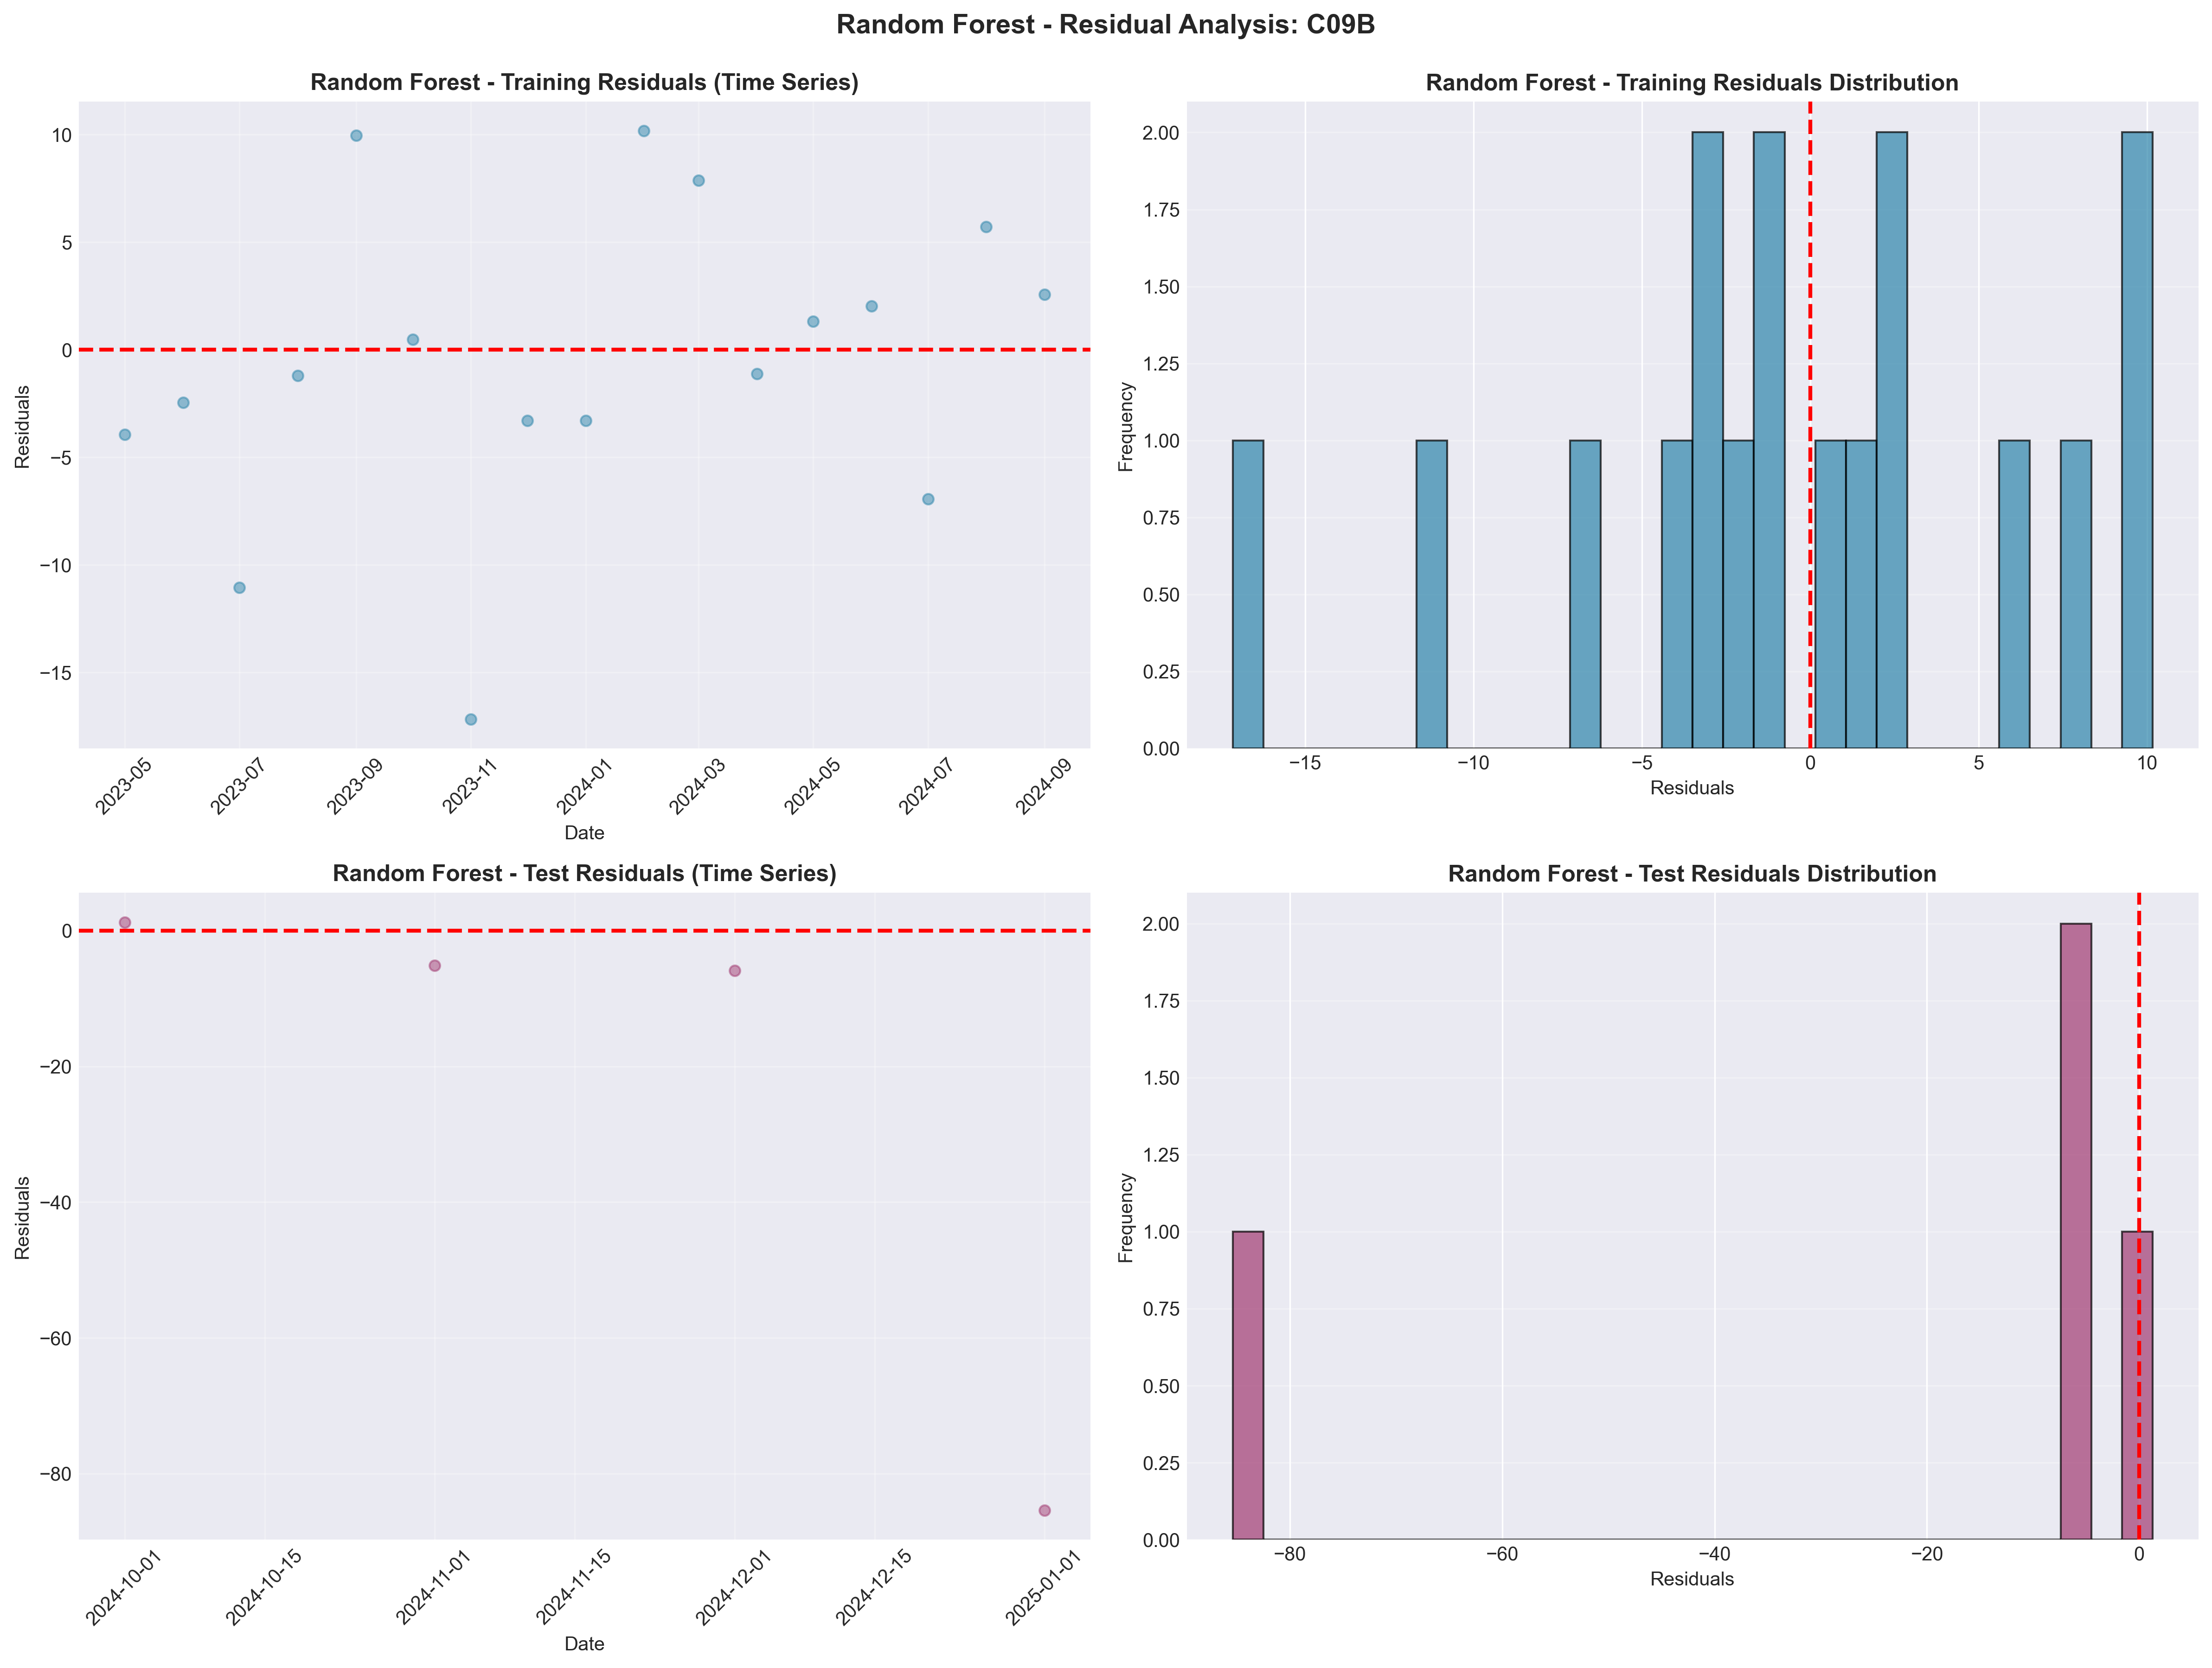

In [8]:
# ============================================================================
# MODEL 4: RANDOM FOREST
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 4: RANDOM FOREST")
print("=" * 80)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
train_metrics_rf = calculate_metrics(y_train, y_train_pred_rf)
test_metrics_rf = calculate_metrics(y_test, y_test_pred_rf)

print("\nTraining Metrics:")
for metric, value in train_metrics_rf.items():
    print(f"  {metric}: {value:.4f}")

print("\nTest Metrics:")
for metric, value in test_metrics_rf.items():
    print(f"  {metric}: {value:.4f}")

# Visualizations
plot_actual_vs_predicted(
    y_train, y_train_pred_rf, y_test, y_test_pred_rf,
    train_dates, test_dates, 'Random Forest', target_atc3,
    output_dir / f'rf_actual_vs_predicted_{target_atc3}.png'
)

plot_residuals(
    y_train, y_train_pred_rf, y_test, y_test_pred_rf,
    train_dates, test_dates, 'Random Forest', target_atc3,
    output_dir / f'rf_residuals_{target_atc3}.png'
)



MODEL 5: LINEAR REGRESSION

Training Metrics:
  MAE: 10.6893
  RMSE: 12.6693
  MAPE: 15.7607
  R2: 0.6471

Test Metrics:
  MAE: 35.6751
  RMSE: 52.6790
  MAPE: 299.0185
  R2: -2.4819


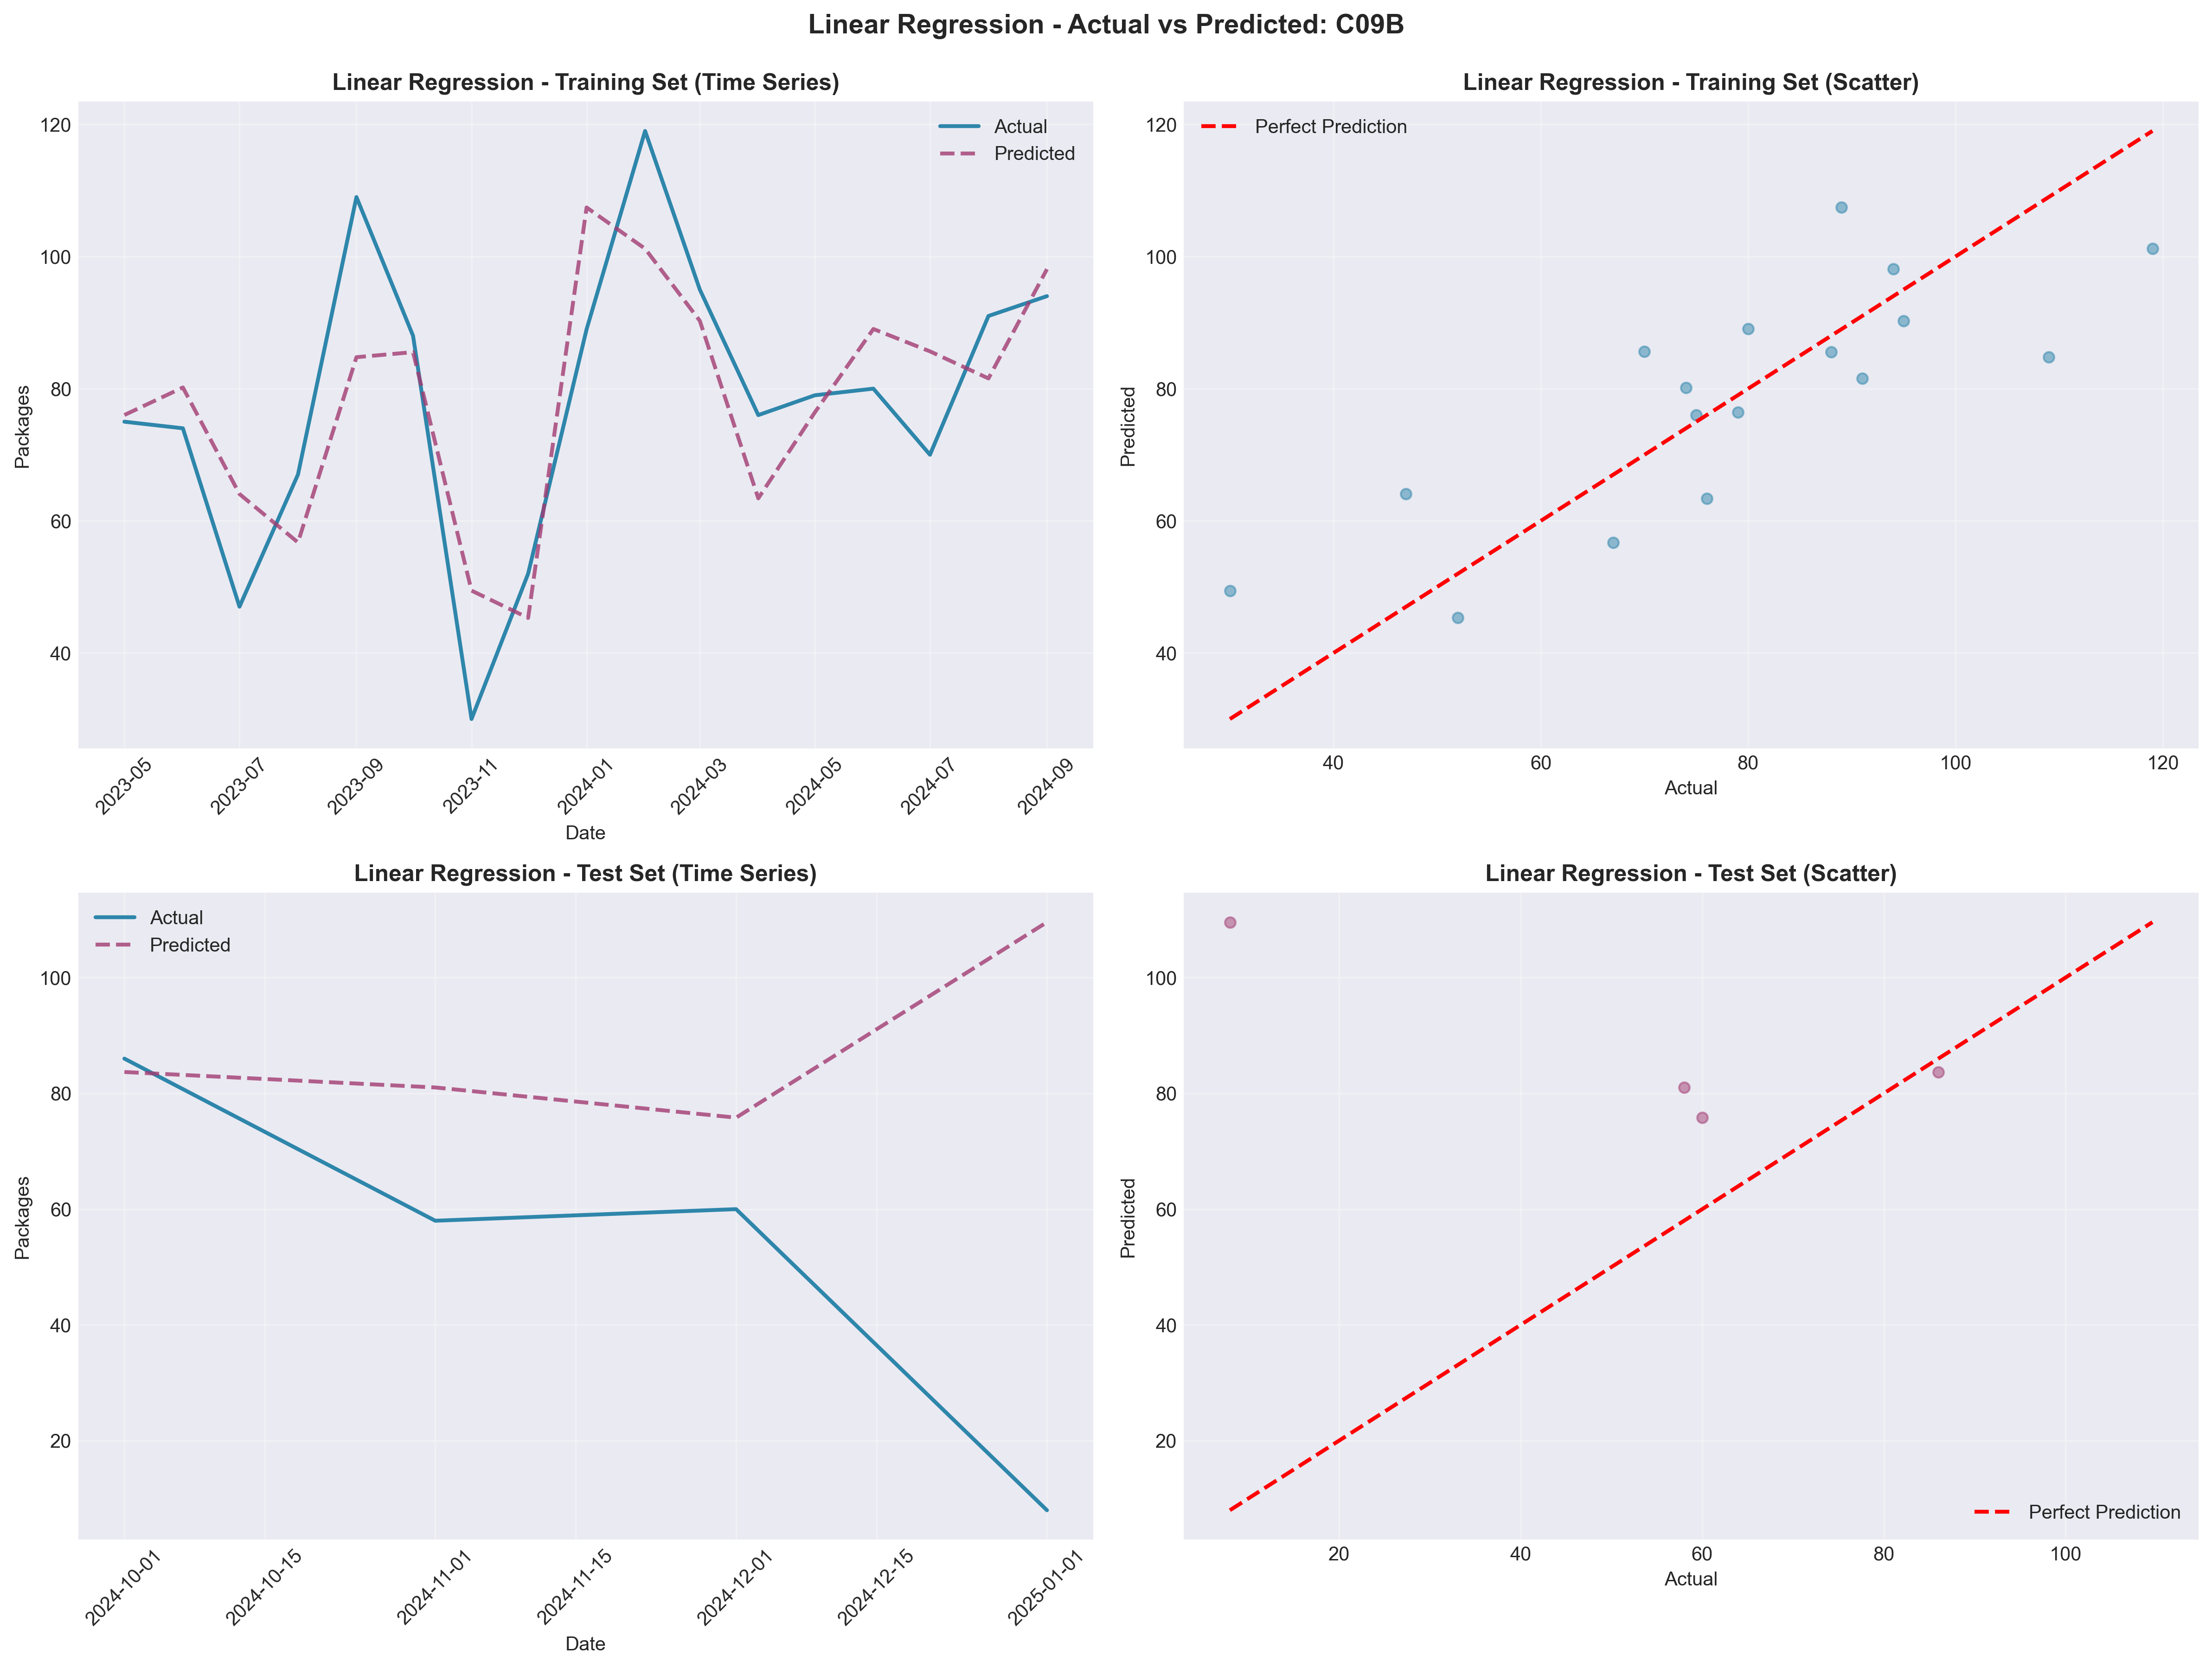

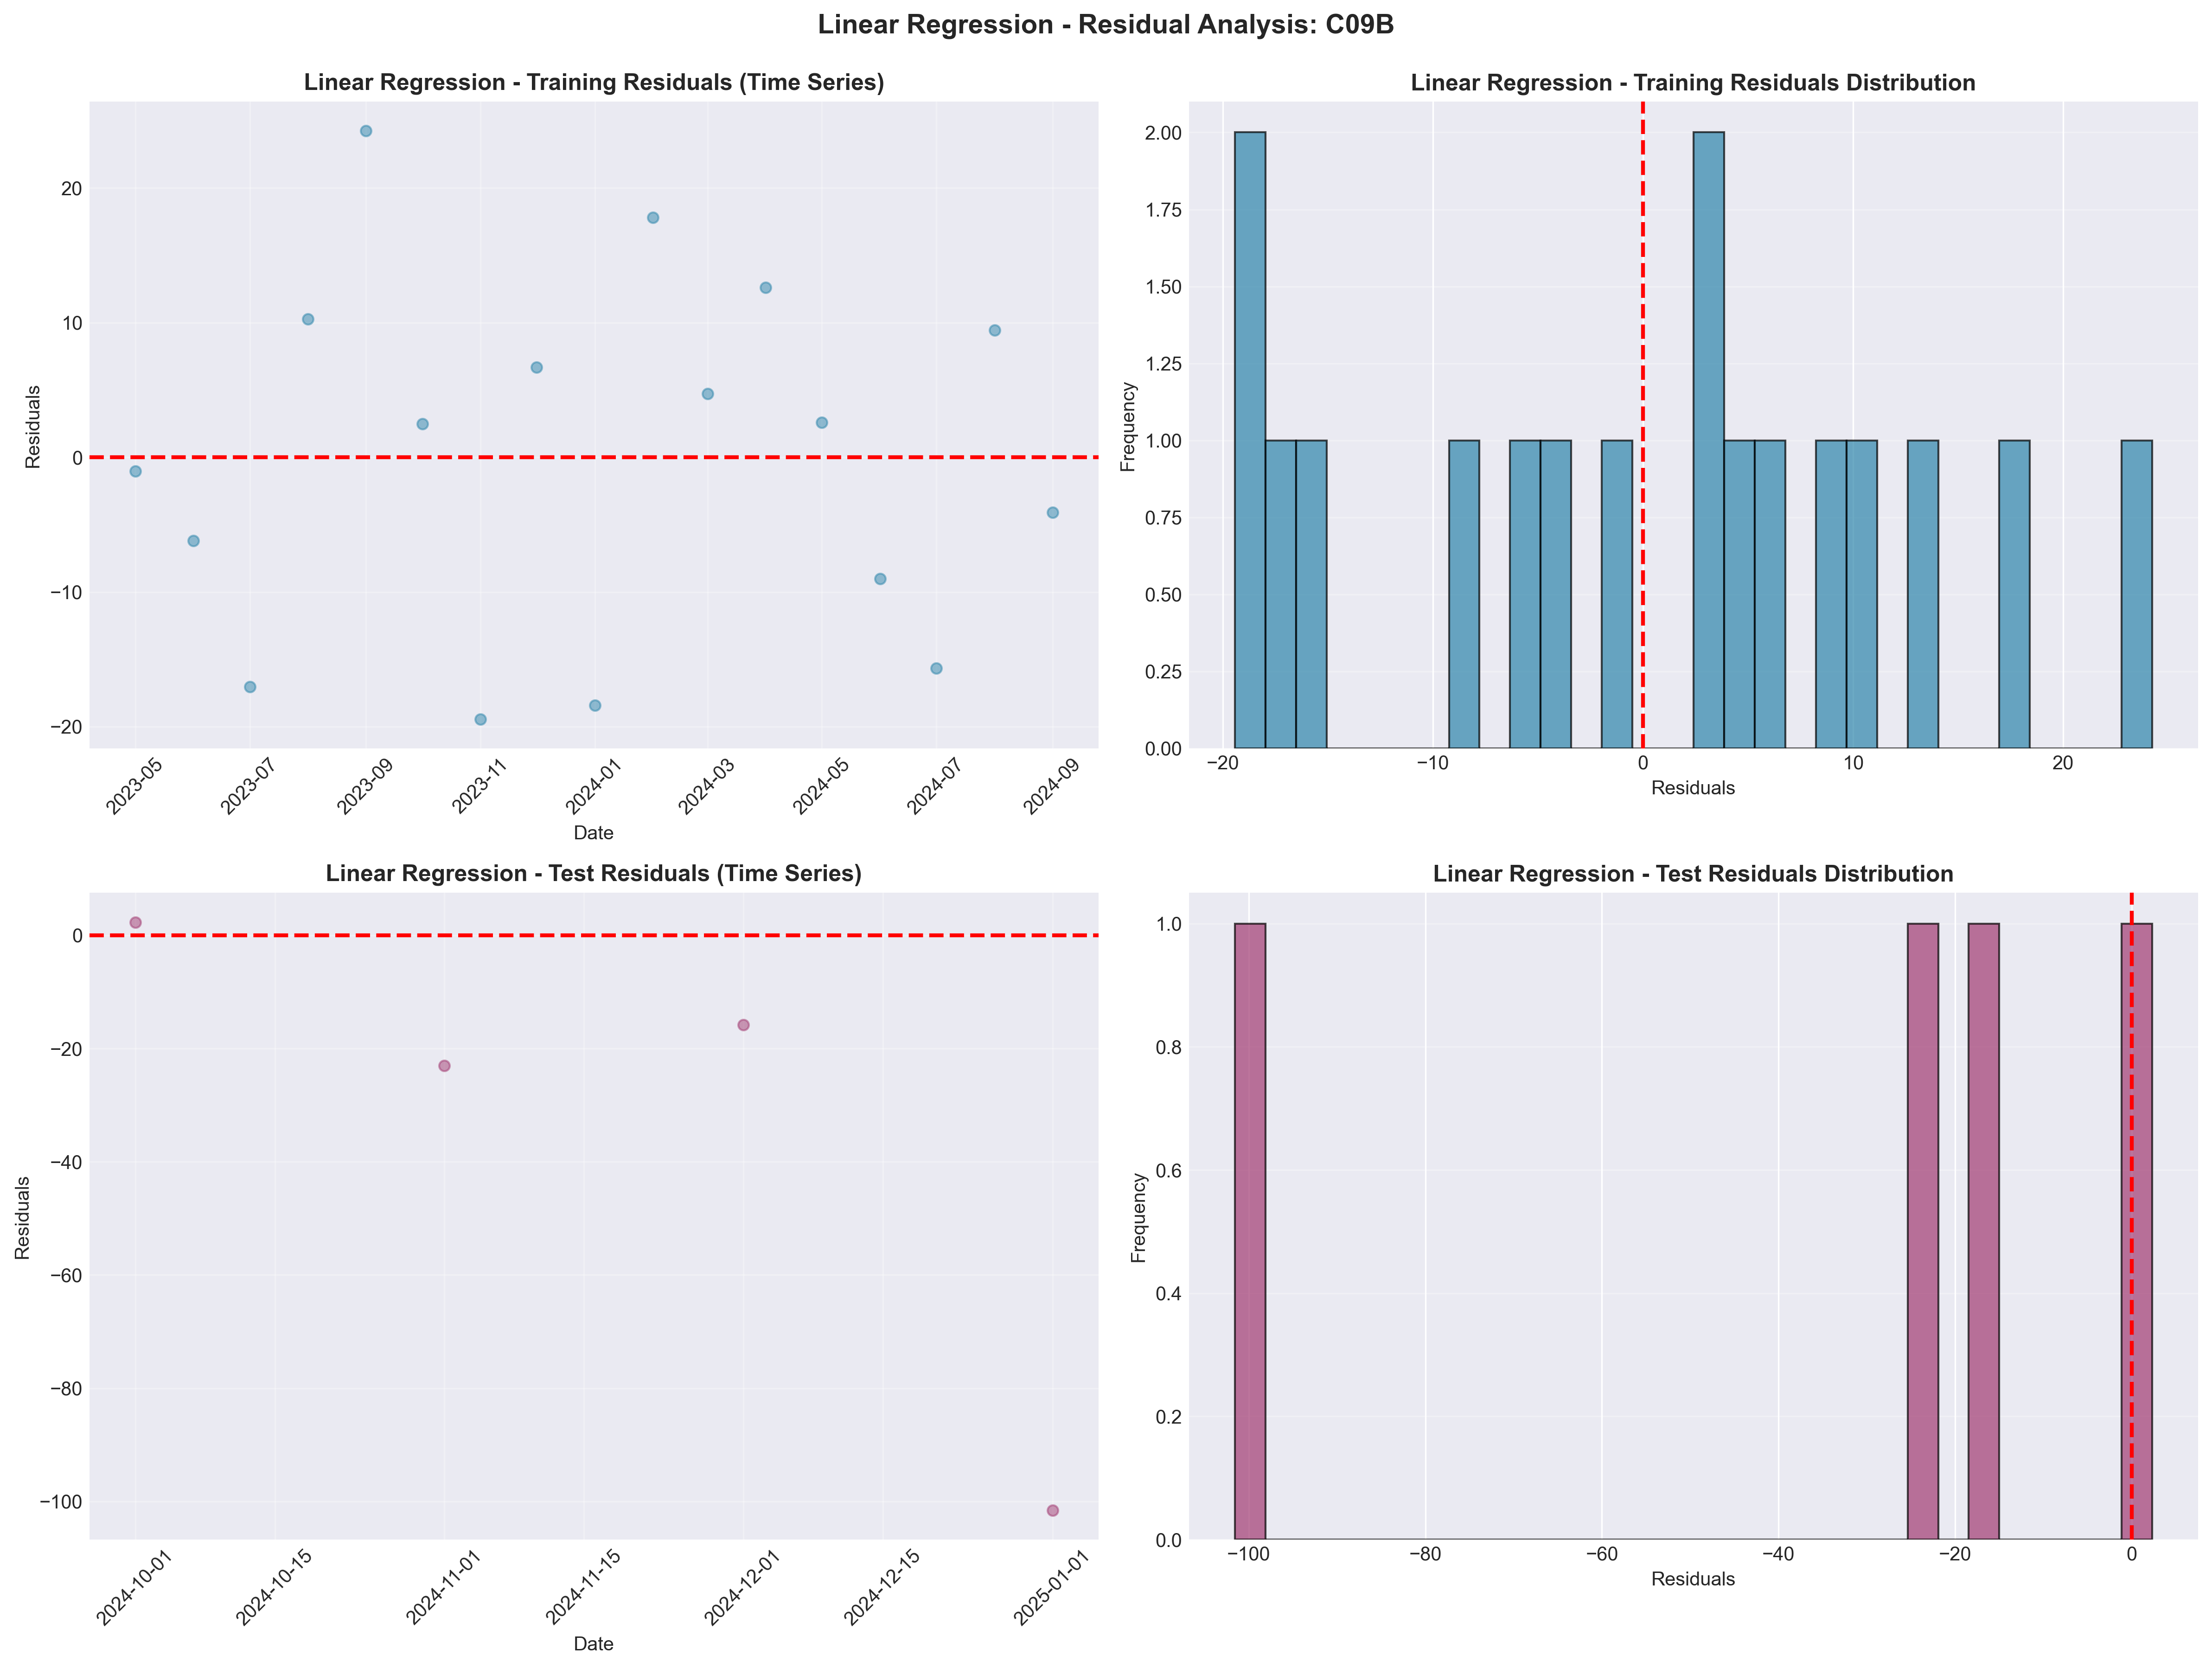

In [9]:
# ============================================================================
# MODEL 5: LINEAR REGRESSION
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 5: LINEAR REGRESSION")
print("=" * 80)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Metrics
train_metrics_lr = calculate_metrics(y_train, y_train_pred_lr)
test_metrics_lr = calculate_metrics(y_test, y_test_pred_lr)

print("\nTraining Metrics:")
for metric, value in train_metrics_lr.items():
    print(f"  {metric}: {value:.4f}")

print("\nTest Metrics:")
for metric, value in test_metrics_lr.items():
    print(f"  {metric}: {value:.4f}")

# Visualizations
plot_actual_vs_predicted(
    y_train, y_train_pred_lr, y_test, y_test_pred_lr,
    train_dates, test_dates, 'Linear Regression', target_atc3,
    output_dir / f'lr_actual_vs_predicted_{target_atc3}.png'
)

plot_residuals(
    y_train, y_train_pred_lr, y_test, y_test_pred_lr,
    train_dates, test_dates, 'Linear Regression', target_atc3,
    output_dir / f'lr_residuals_{target_atc3}.png'
)



MODEL COMPARISON

Model Comparison (Test Set):
--------------------------------------------------------------------------------
            Model  Test_MAE  Test_RMSE  Test_MAPE   Test_R2
          XGBoost 28.522617  41.497964 231.270839 -1.160704
    Random Forest 24.412500  42.882184 242.160606 -1.307254
Linear Regression 35.675132  52.678975 299.018451 -2.481900
          Prophet 38.836500  48.797436 266.691497 -1.987691
           SARIMA 26.617400  33.187952 178.401153 -0.381983

Comparison saved to: ../forecast_plots/model_comparison_C09B.csv


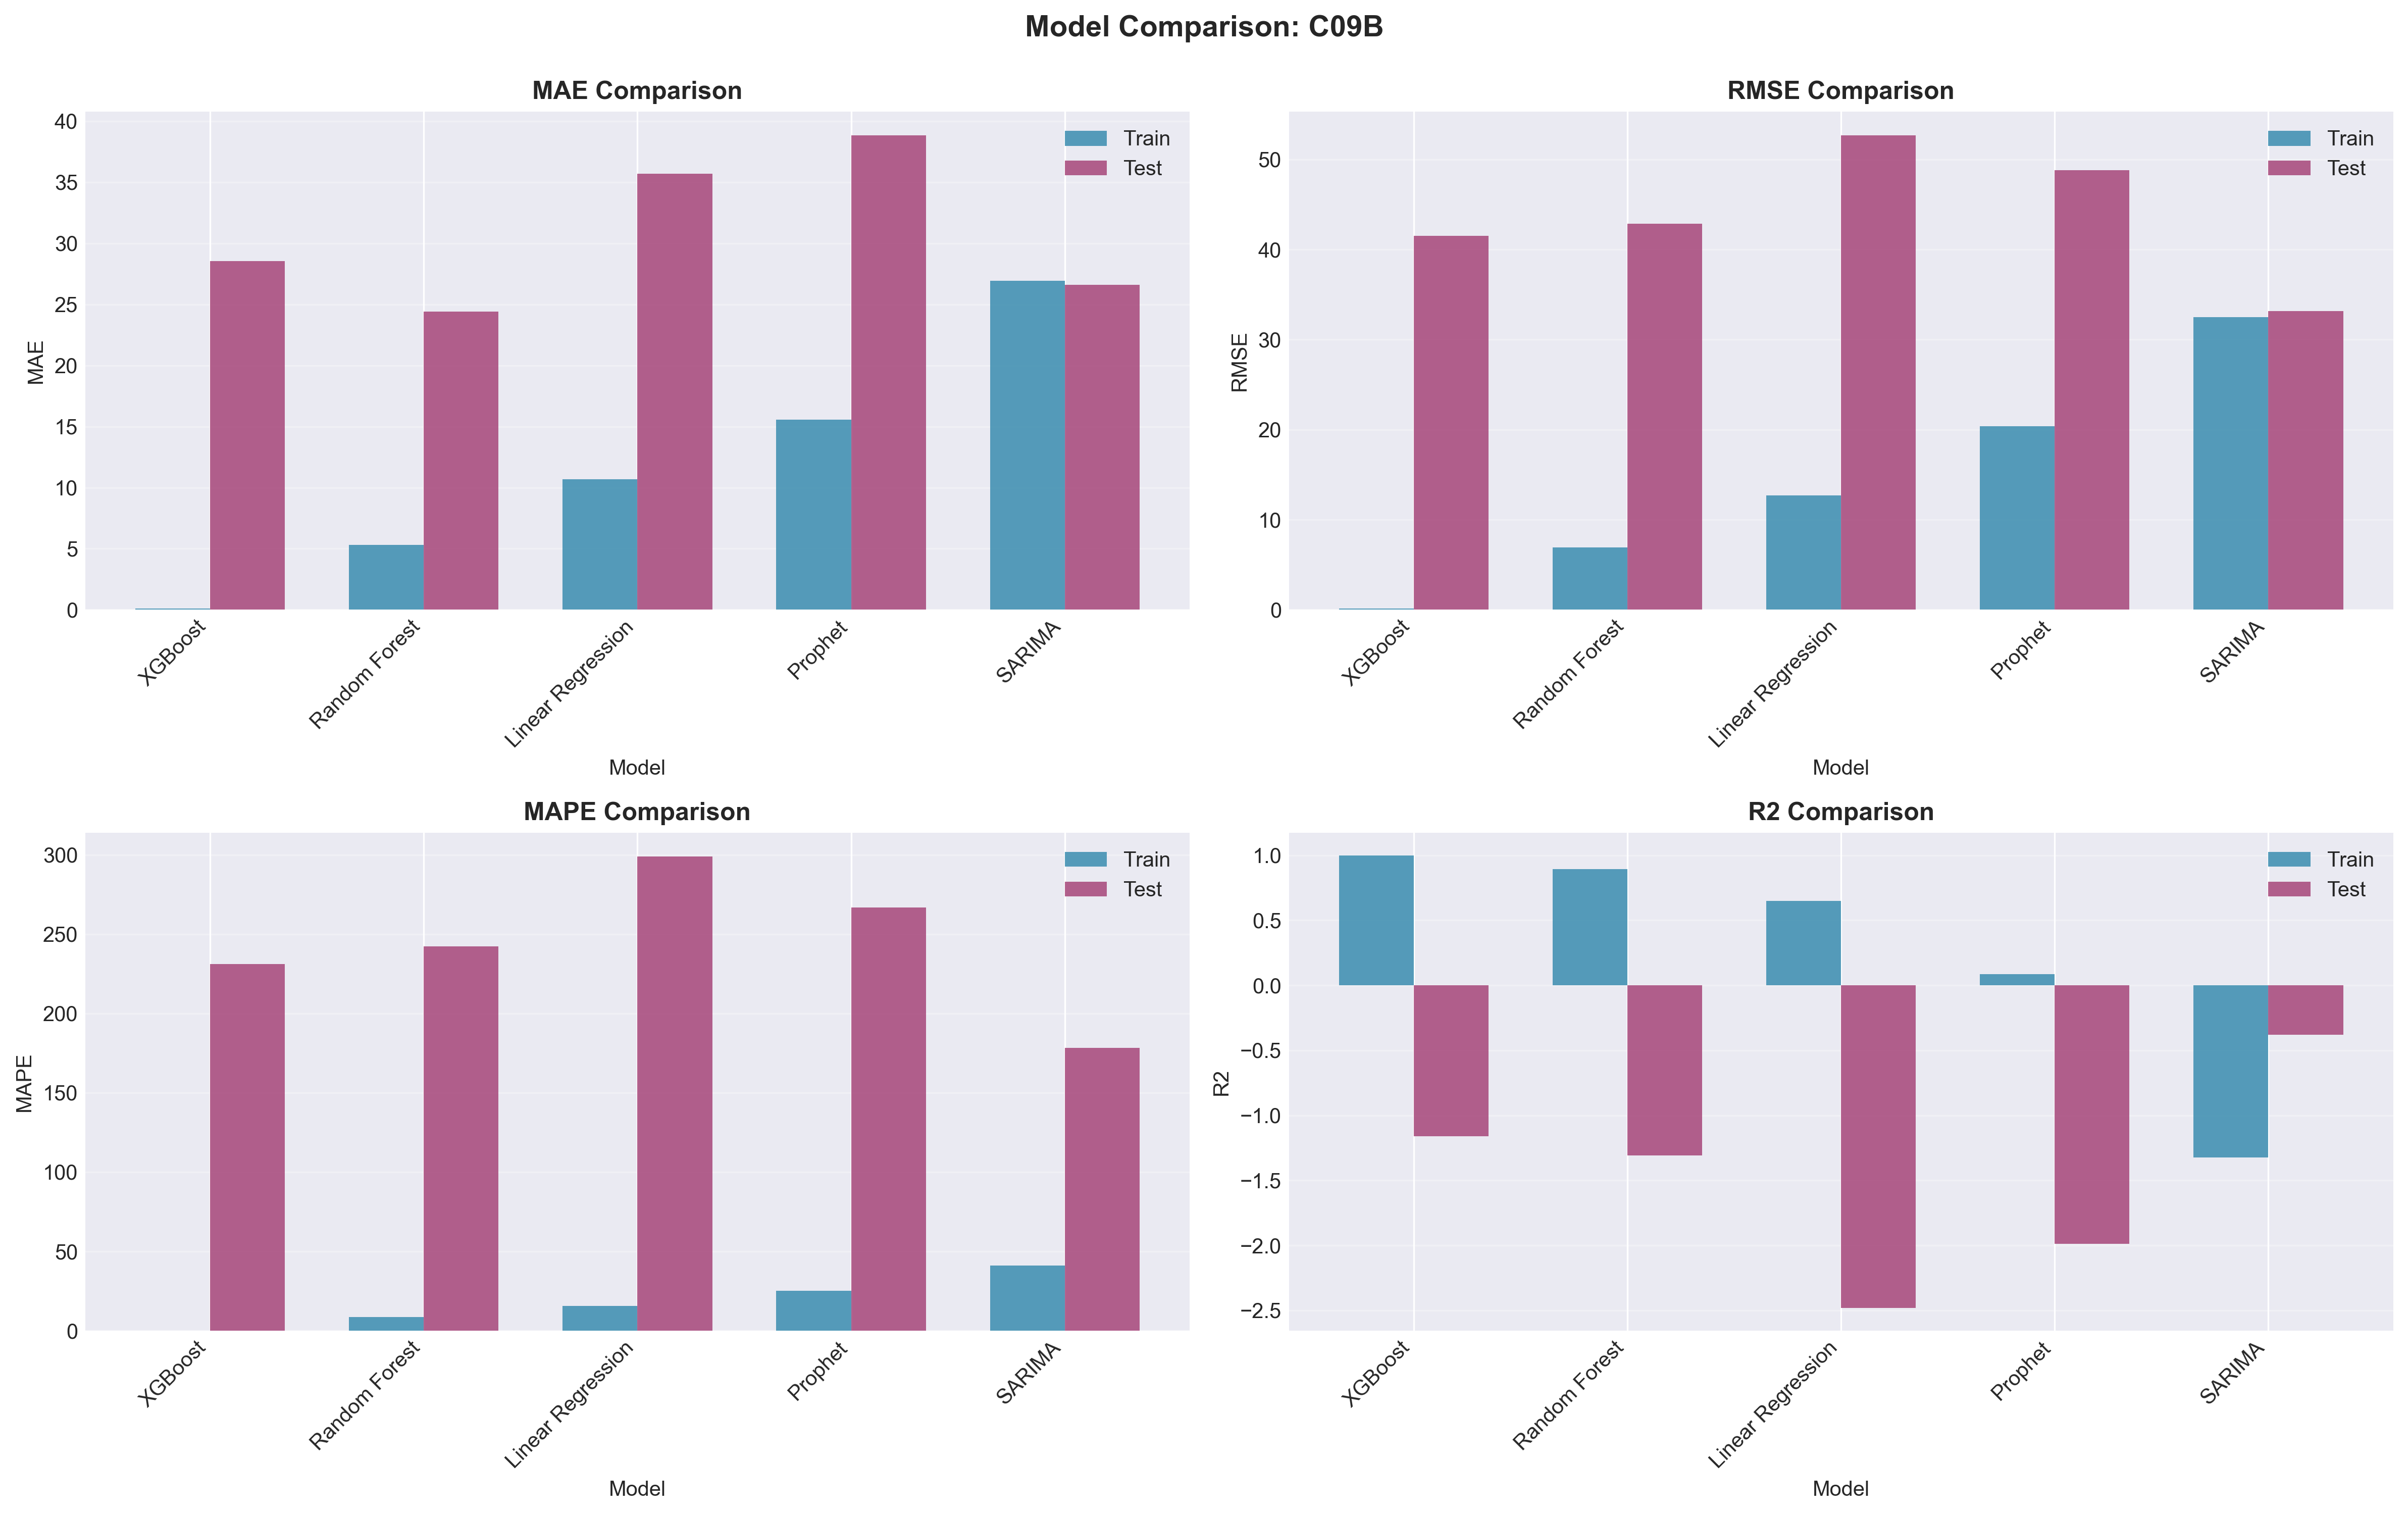

In [10]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

# Collect all metrics
models_comparison = {
    'XGBoost': {'train': train_metrics_xgb, 'test': test_metrics_xgb},
    'Random Forest': {'train': train_metrics_rf, 'test': test_metrics_rf},
    'Linear Regression': {'train': train_metrics_lr, 'test': test_metrics_lr},
    'Prophet': {'train': train_metrics_prophet, 'test': test_metrics_prophet},
}

if train_metrics_sarima is not None:
    models_comparison['SARIMA'] = {'train': train_metrics_sarima, 'test': test_metrics_sarima}

# Create comparison DataFrame
comparison_data = []
for model_name, metrics in models_comparison.items():
    comparison_data.append({
        'Model': model_name,
        'Train_MAE': metrics['train']['MAE'],
        'Train_RMSE': metrics['train']['RMSE'],
        'Train_MAPE': metrics['train']['MAPE'],
        'Train_R2': metrics['train']['R2'],
        'Test_MAE': metrics['test']['MAE'],
        'Test_RMSE': metrics['test']['RMSE'],
        'Test_MAPE': metrics['test']['MAPE'],
        'Test_R2': metrics['test']['R2'],
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison (Test Set):")
print("-" * 80)
print(comparison_df[['Model', 'Test_MAE', 'Test_RMSE', 'Test_MAPE', 'Test_R2']].to_string(index=False))

# Save comparison
comparison_path = output_dir / f'model_comparison_{target_atc3}.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"\nComparison saved to: {comparison_path}")

# Visualization: Compare test metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics_to_plot = ['MAE', 'RMSE', 'MAPE', 'R2']
for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2
    
    train_values = [models_comparison[model]['train'][metric] for model in comparison_df['Model']]
    test_values = [models_comparison[model]['test'][metric] for model in comparison_df['Model']]
    
    x = np.arange(len(comparison_df['Model']))
    width = 0.35
    
    axes[row, col].bar(x - width/2, train_values, width, label='Train', alpha=0.8, color='#2E86AB')
    axes[row, col].bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='#A23B72')
    axes[row, col].set_xlabel('Model', fontsize=10)
    axes[row, col].set_ylabel(metric, fontsize=10)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_xticks(x)
    axes[row, col].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Model Comparison: {target_atc3}', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir / f'model_comparison_{target_atc3}.png', bbox_inches='tight', dpi=300)
plt.show()



FORECAST NEXT MONTH
Last observed month: 2025-01
Forecasting for: 2025-02

Forecasts for next month:
----------------------------------------
  XGBoost: 103.19
  Random Forest: 89.38
  Linear Regression: 83.66
  Prophet: 95.03
  SARIMA: 107.62

  Average: 95.78


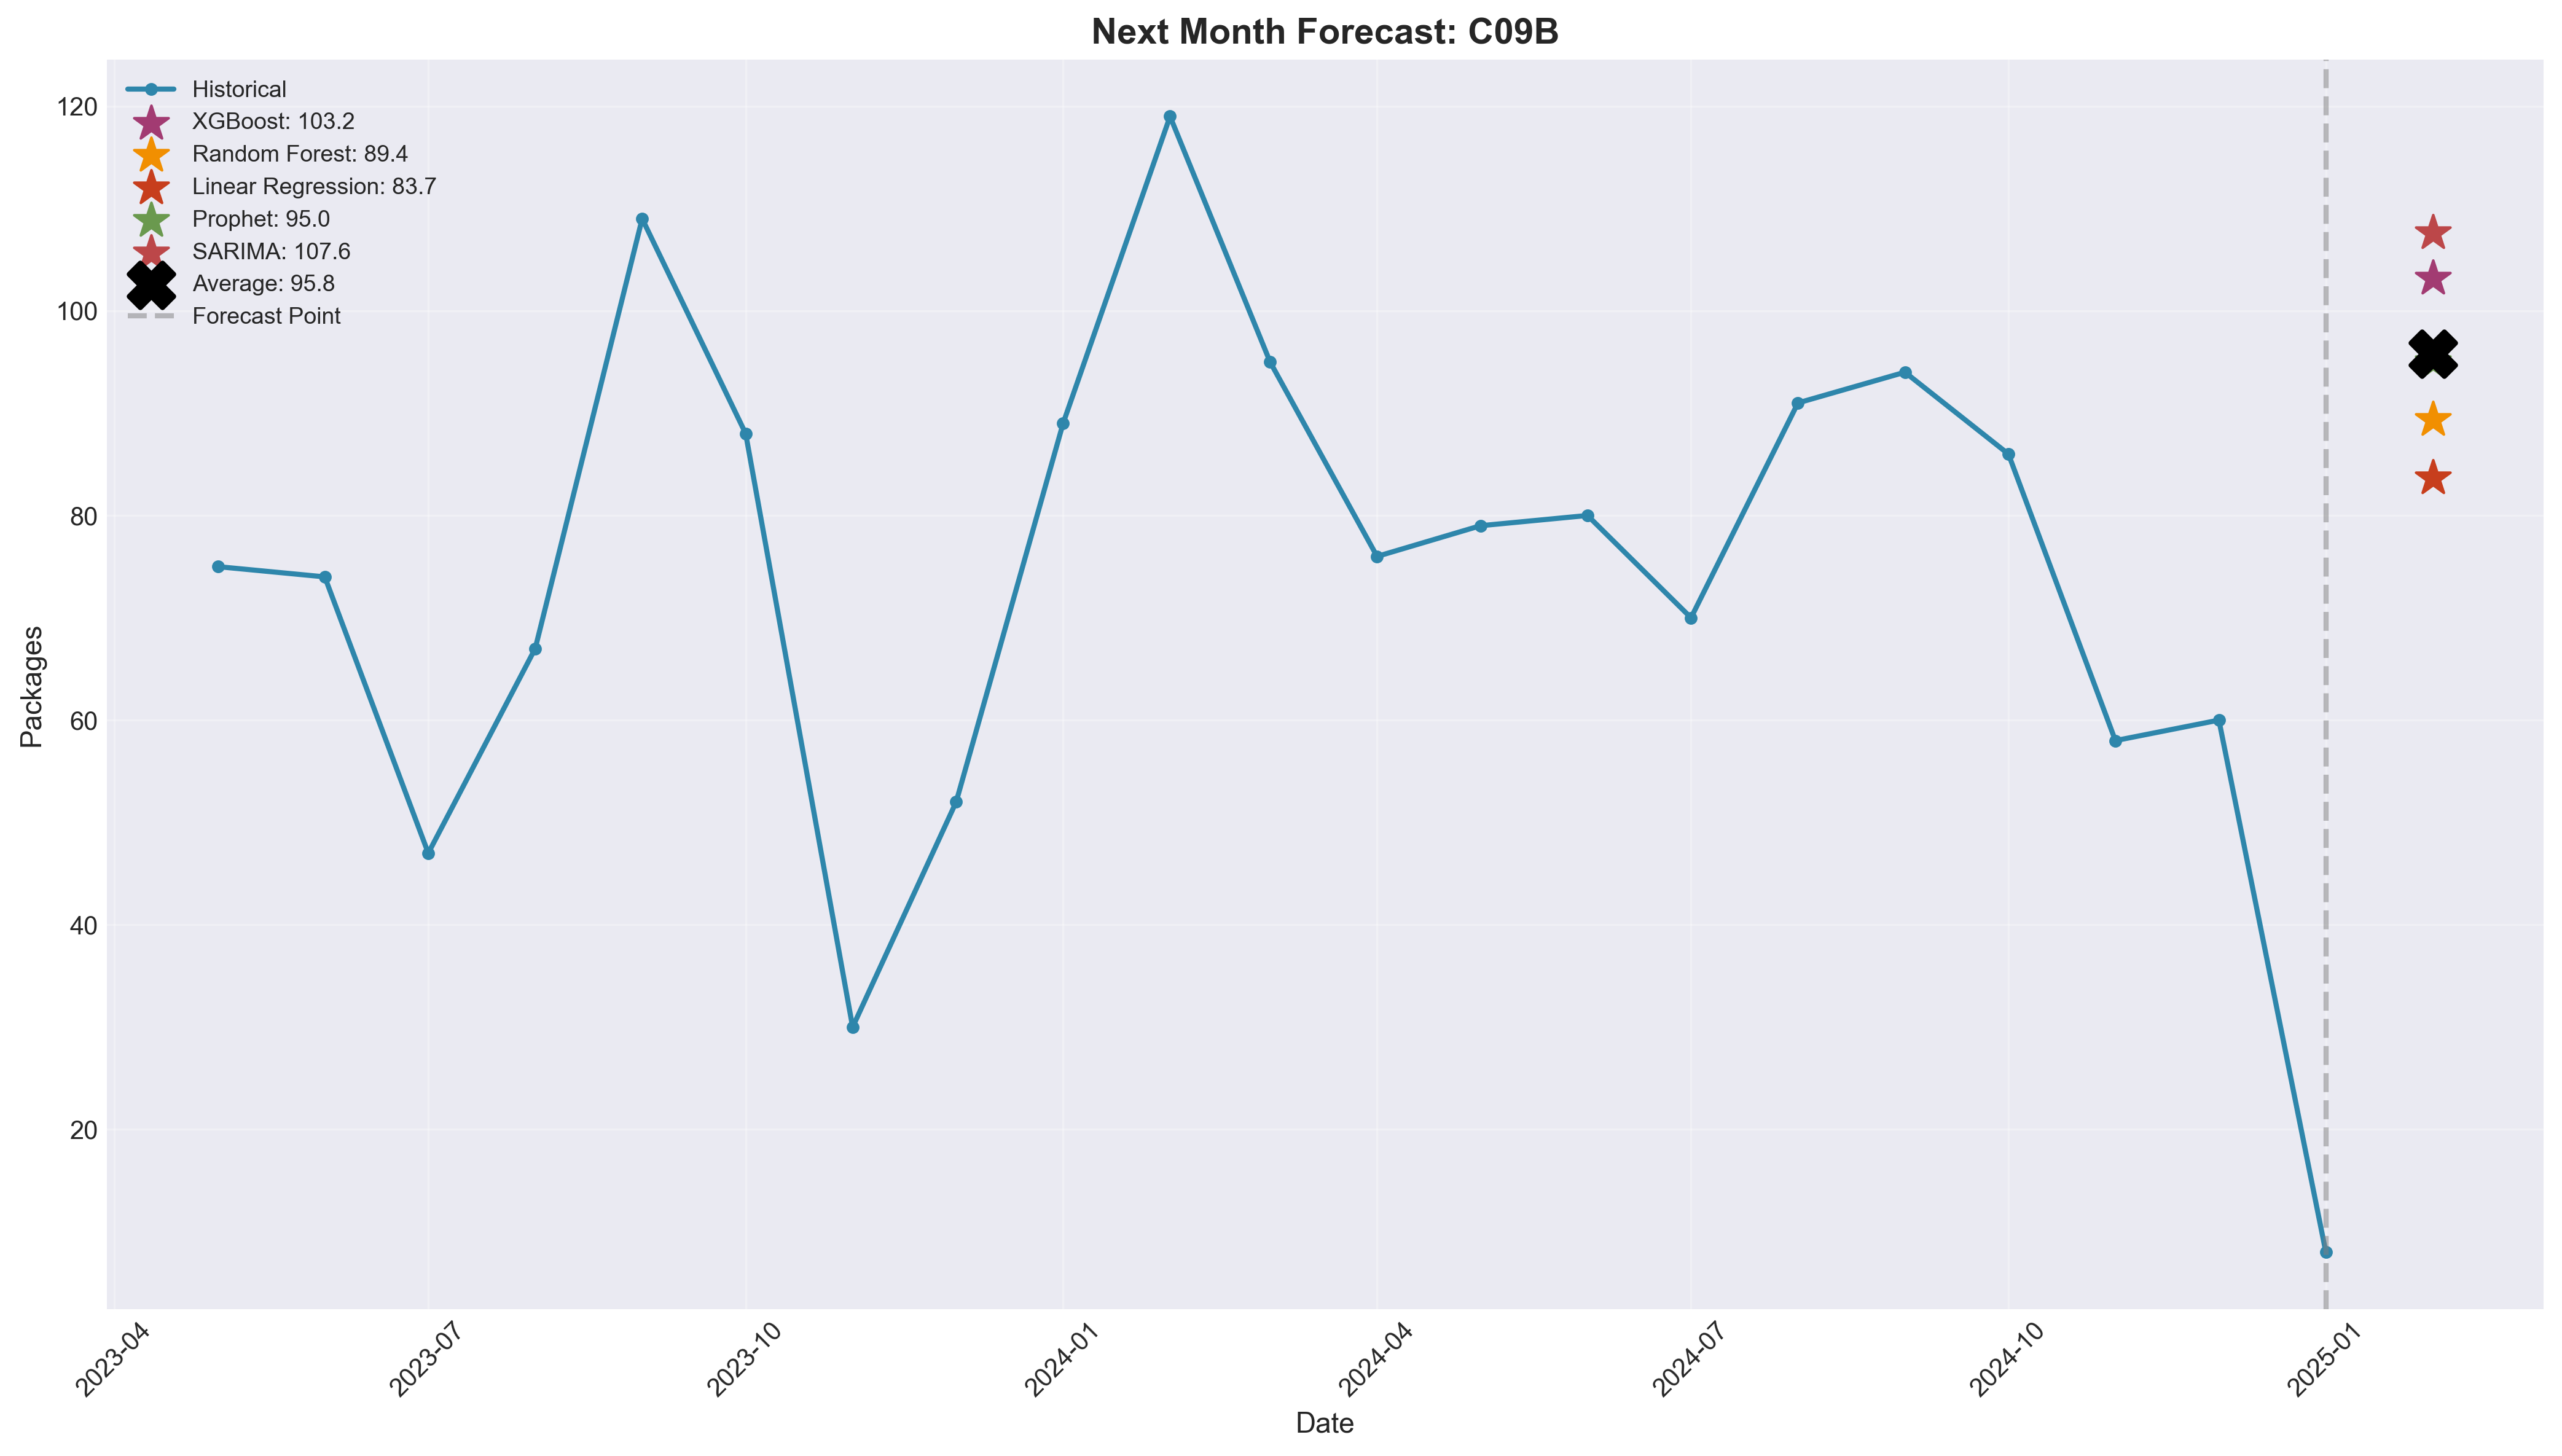


Forecast saved to: ../forecast_plots/next_month_forecast_C09B.csv


In [11]:
# ============================================================================
# FORECAST NEXT MONTH
# ============================================================================

print("\n" + "=" * 80)
print("FORECAST NEXT MONTH")
print("=" * 80)

# Get the last date and prepare next month
last_date = data['month_start'].max()
next_month = last_date + pd.DateOffset(months=1)

print(f"Last observed month: {last_date.strftime('%Y-%m')}")
print(f"Forecasting for: {next_month.strftime('%Y-%m')}")

# Prepare features for next month
last_row = data.iloc[-1]
next_month_features = pd.DataFrame({
    'month': [next_month.month],
    'year': [next_month.year],
    'month_index': [last_row['month_index'] + 1],
    'packages_lag1': [last_row['packages']],
    'packages_lag2': [last_row['packages_lag1']],
    'packages_lag3': [last_row['packages_lag2']],
})

# Forecasts from different models
forecasts = {}

# XGBoost (predict in log space, then back-transform)
xgb_forecast_log = xgb_model.predict(next_month_features[feature_cols].values)[0]
forecasts['XGBoost'] = np.expm1(xgb_forecast_log)

# Random Forest
forecasts['Random Forest'] = rf_model.predict(next_month_features[feature_cols].values)[0]

# Linear Regression
forecasts['Linear Regression'] = lr_model.predict(next_month_features[feature_cols].values)[0]

# Prophet (on original scale, with bounds)
prophet_future = pd.DataFrame({'ds': [next_month]})
prophet_forecast = prophet_model.predict(prophet_future)
prophet_pred = prophet_forecast['yhat'].iloc[0]
# Clip to reasonable bounds
max_observed = data['packages'].max()
forecasts['Prophet'] = max(0, min(prophet_pred, max_observed * 10))

# SARIMA/ARIMA
if 'sarima_fitted' in locals() or 'arima_fitted' in locals():
    if 'sarima_fitted' in locals():
        sarima_forecast = sarima_fitted.forecast(steps=1)
        forecasts['SARIMA'] = sarima_forecast.iloc[0]
    elif 'arima_fitted' in locals():
        arima_forecast = arima_fitted.forecast(steps=1)
        forecasts['ARIMA'] = arima_forecast.iloc[0]

# Average forecast
avg_forecast = np.mean(list(forecasts.values()))

print("\nForecasts for next month:")
print("-" * 40)
for model, forecast in forecasts.items():
    print(f"  {model}: {forecast:.2f}")
print(f"\n  Average: {avg_forecast:.2f}")

# Visualization: Forecast plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot historical data
ax.plot(data['month_start'], data['packages'], 
       label='Historical', linewidth=2, color='#2E86AB', marker='o', markersize=4)

# Plot forecasts
colors = ['#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4749']
for idx, (model, forecast) in enumerate(forecasts.items()):
    ax.scatter(next_month, forecast, s=200, color=colors[idx % len(colors)], 
              label=f'{model}: {forecast:.1f}', marker='*', zorder=5)

# Plot average
ax.scatter(next_month, avg_forecast, s=300, color='black', 
          label=f'Average: {avg_forecast:.1f}', marker='X', zorder=6, linewidths=2)

# Add vertical line to separate historical and forecast
ax.axvline(x=last_date, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Forecast Point')

ax.set_title(f'Next Month Forecast: {target_atc3}', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Packages', fontsize=11)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / f'next_month_forecast_{target_atc3}.png', bbox_inches='tight', dpi=300)
plt.show()

# Save forecasts
forecast_df = pd.DataFrame({
    'atc3_code': [target_atc3],
    'forecast_date': [next_month],
    **{f'{model}_forecast': [forecast] for model, forecast in forecasts.items()},
    'average_forecast': [avg_forecast]
})

forecast_path = output_dir / f'next_month_forecast_{target_atc3}.csv'
forecast_df.to_csv(forecast_path, index=False)
print(f"\nForecast saved to: {forecast_path}")


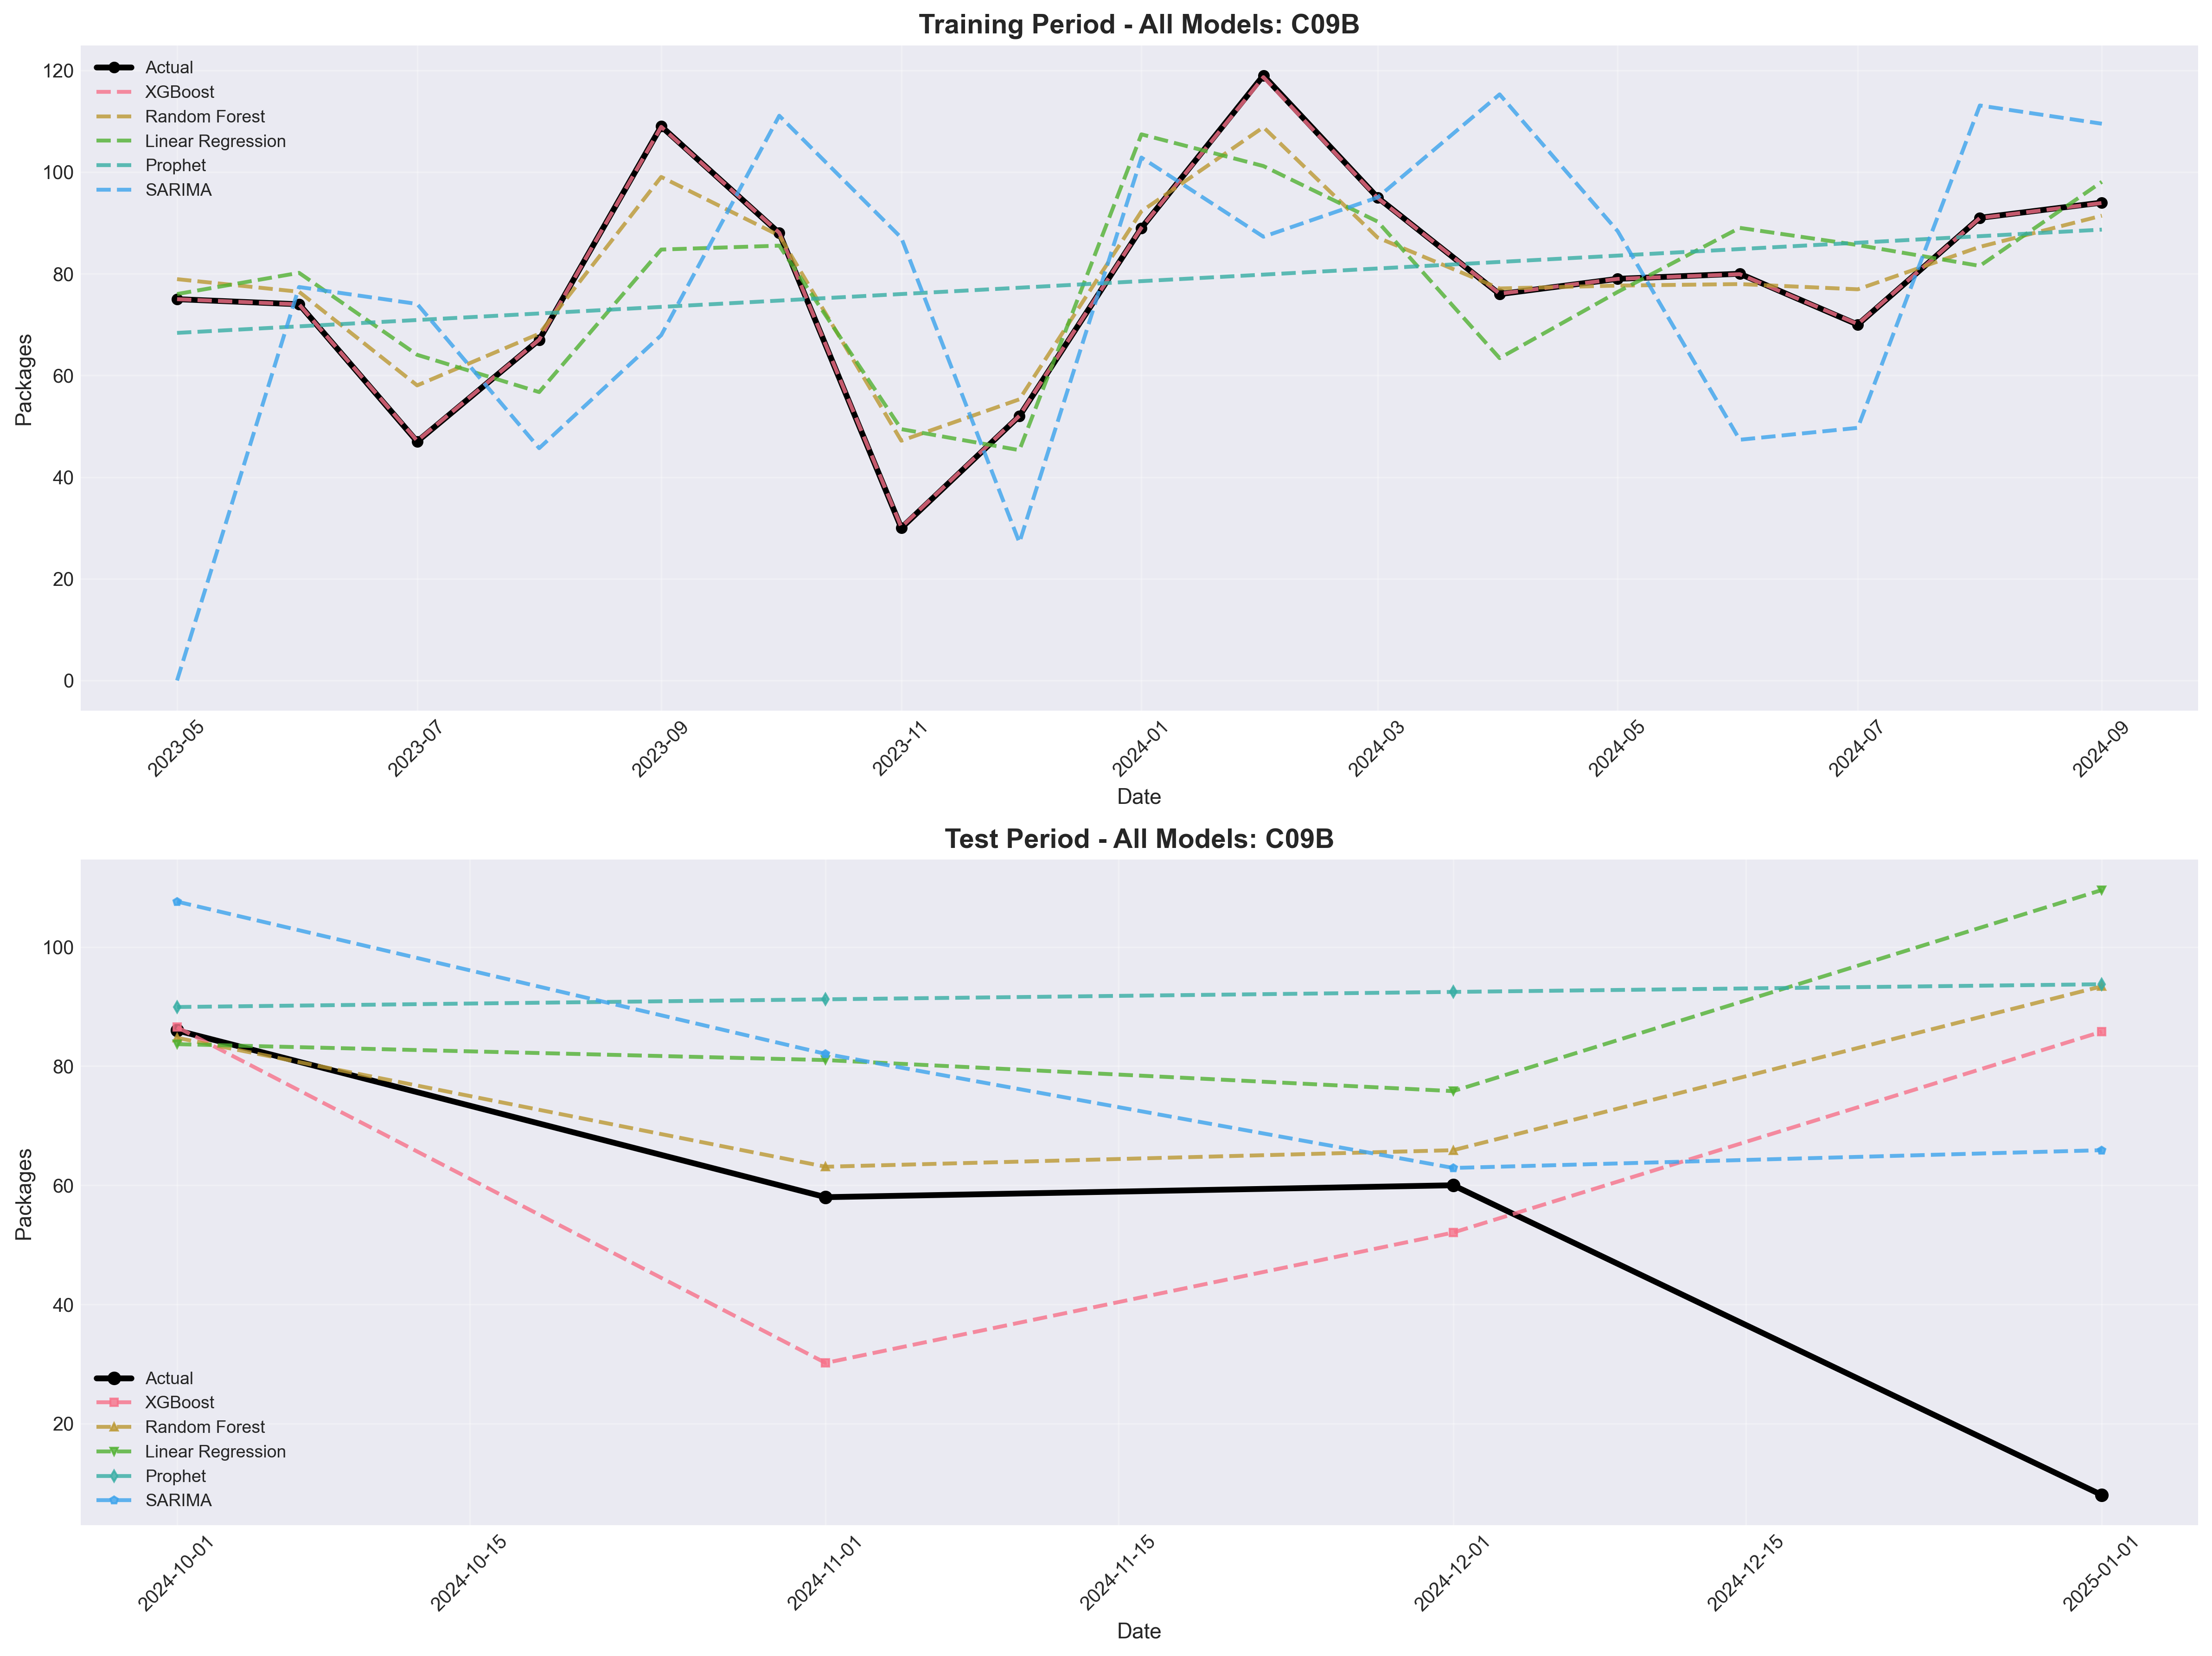

In [12]:
# ============================================================================
# ALL MODELS OVERLAY PLOT
# ============================================================================

# Create a comprehensive plot showing all models' predictions
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Training period
axes[0].plot(train_dates, y_train, label='Actual', linewidth=3, color='black', marker='o', markersize=5)
axes[0].plot(train_dates, y_train_pred_xgb, label='XGBoost', linewidth=2, linestyle='--', alpha=0.8)
axes[0].plot(train_dates, y_train_pred_rf, label='Random Forest', linewidth=2, linestyle='--', alpha=0.8)
axes[0].plot(train_dates, y_train_pred_lr, label='Linear Regression', linewidth=2, linestyle='--', alpha=0.8)
axes[0].plot(train_dates, y_train_pred_prophet, label='Prophet', linewidth=2, linestyle='--', alpha=0.8)
if y_train_pred_sarima is not None:
    axes[0].plot(train_dates, y_train_pred_sarima, label='SARIMA', linewidth=2, linestyle='--', alpha=0.8)

axes[0].set_title(f'Training Period - All Models: {target_atc3}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Packages', fontsize=11)
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Test period
axes[1].plot(test_dates, y_test, label='Actual', linewidth=3, color='black', marker='o', markersize=6)
axes[1].plot(test_dates, y_test_pred_xgb, label='XGBoost', linewidth=2, linestyle='--', alpha=0.8, marker='s', markersize=4)
axes[1].plot(test_dates, y_test_pred_rf, label='Random Forest', linewidth=2, linestyle='--', alpha=0.8, marker='^', markersize=4)
axes[1].plot(test_dates, y_test_pred_lr, label='Linear Regression', linewidth=2, linestyle='--', alpha=0.8, marker='v', markersize=4)
axes[1].plot(test_dates, y_test_pred_prophet, label='Prophet', linewidth=2, linestyle='--', alpha=0.8, marker='d', markersize=4)
if y_test_pred_sarima is not None:
    axes[1].plot(test_dates, y_test_pred_sarima, label='SARIMA', linewidth=2, linestyle='--', alpha=0.8, marker='p', markersize=4)

axes[1].set_title(f'Test Period - All Models: {target_atc3}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Packages', fontsize=11)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / f'all_models_overlay_{target_atc3}.png', bbox_inches='tight', dpi=300)
plt.show()


In [13]:
# ============================================================================
# BATCH FORECASTING FOR ALL TOP 10 ATC3 CODES
# ============================================================================

print("\n" + "=" * 80)
print("BATCH FORECASTING FOR ALL TOP 10 ATC3 CODES")
print("=" * 80)

# Store all forecasts
all_forecasts = []

for idx, atc3_code in enumerate(top_codes, 1):
    print(f"\n[{idx}/10] Processing ATC3 code: {atc3_code}")
    print("-" * 60)
    
    try:
        # Filter data for this ATC3 code
        data_atc3 = df[df['atc3_code'] == atc3_code].copy()
        data_atc3 = data_atc3.sort_values('month_start').reset_index(drop=True)
        
        # Exclude January 2025 from data (it's the forecast month, not training/test data)
        data_atc3 = data_atc3[data_atc3['month_start'] < pd.Timestamp('2025-01-01')].copy()
        
        # Skip if not enough data
        if len(data_atc3) < 6:
            print(f"  Skipping {atc3_code}: insufficient data ({len(data_atc3)} months)")
            continue
        
        # Train/Test split: Fixed date split at September 1, 2024
        split_date = pd.Timestamp('2024-09-01')
        train_data_atc3 = data_atc3[data_atc3['month_start'] < split_date].copy()
        
        # Prepare features
        feature_cols = ['month', 'year', 'month_index', 'packages_lag1', 'packages_lag2', 'packages_lag3']
        X_train_atc3 = train_data_atc3[feature_cols].values
        y_train_atc3 = train_data_atc3['packages'].values
        
        # Get last date (December 2024) and forecast month (January 2025)
        last_date = data_atc3['month_start'].max()  # Should be December 2024
        next_month = pd.Timestamp('2025-01-01')  # Forecast for January 2025
        
        # Prepare features for next month (use last row from filtered data)
        last_row = data_atc3.iloc[-1]
        next_month_features = pd.DataFrame({
            'month': [next_month.month],
            'year': [next_month.year],
            'month_index': [last_row['month_index'] + 1],
            'packages_lag1': [last_row['packages']],
            'packages_lag2': [last_row['packages_lag1']],
            'packages_lag3': [last_row['packages_lag2']],
        })
        
        # Initialize forecast dictionary
        forecast_dict = {
            'atc3_code': atc3_code,
            'forecast_date': next_month,
            'last_observed_date': last_date,
            'last_observed_value': last_row['packages'],
            'n_months_history': len(data_atc3)
        }
        
        # XGBoost forecast
        try:
            y_train_log_atc3 = np.log1p(y_train_atc3)
            xgb_model_atc3 = xgb.XGBRegressor(
                n_estimators=100, max_depth=5, learning_rate=0.1,
                random_state=42, n_jobs=-1
            )
            xgb_model_atc3.fit(X_train_atc3, y_train_log_atc3)
            xgb_forecast_log = xgb_model_atc3.predict(next_month_features[feature_cols].values)[0]
            forecast_dict['xgb_forecast'] = np.expm1(xgb_forecast_log)
        except Exception as e:
            print(f"  XGBoost failed: {e}")
            forecast_dict['xgb_forecast'] = np.nan
        
        # Random Forest forecast
        try:
            rf_model_atc3 = RandomForestRegressor(
                n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
            )
            rf_model_atc3.fit(X_train_atc3, y_train_atc3)
            forecast_dict['rf_forecast'] = rf_model_atc3.predict(next_month_features[feature_cols].values)[0]
        except Exception as e:
            print(f"  Random Forest failed: {e}")
            forecast_dict['rf_forecast'] = np.nan
        
        # Linear Regression forecast
        try:
            lr_model_atc3 = LinearRegression()
            lr_model_atc3.fit(X_train_atc3, y_train_atc3)
            forecast_dict['lr_forecast'] = lr_model_atc3.predict(next_month_features[feature_cols].values)[0]
        except Exception as e:
            print(f"  Linear Regression failed: {e}")
            forecast_dict['lr_forecast'] = np.nan
        
        # Prophet forecast (fixed - using additive on original scale)
        try:
            prophet_train_atc3 = pd.DataFrame({
                'ds': train_data_atc3['month_start'],
                'y': train_data_atc3['packages']  # Original scale
            })
            prophet_model_atc3 = Prophet(
                yearly_seasonality=True if len(train_data_atc3) >= 24 else False,
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode='additive',  # More stable
                growth='linear'
            )
            prophet_model_atc3.changepoint_prior_scale = 0.05
            prophet_model_atc3.fit(prophet_train_atc3)
            prophet_future = pd.DataFrame({'ds': [next_month]})
            prophet_forecast = prophet_model_atc3.predict(prophet_future)
            prophet_pred = prophet_forecast['yhat'].iloc[0]
            # Clip to reasonable bounds
            max_observed_atc3 = data_atc3['packages'].max()
            forecast_dict['prophet_forecast'] = max(0, min(prophet_pred, max_observed_atc3 * 10))
        except Exception as e:
            print(f"  Prophet failed: {e}")
            forecast_dict['prophet_forecast'] = np.nan
        
        # SARIMA/ARIMA forecast (fixed - adaptive order selection)
        try:
            train_ts_atc3 = train_data_atc3.set_index('month_start')['packages']
            n_train_atc3 = len(train_ts_atc3)
            
            if n_train_atc3 >= 24:
                sarima_model_atc3 = SARIMAX(
                    train_ts_atc3,
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
            elif n_train_atc3 >= 12:
                sarima_model_atc3 = SARIMAX(
                    train_ts_atc3,
                    order=(1, 1, 1),
                    seasonal_order=(0, 1, 1, min(12, n_train_atc3 // 2)),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
            else:
                sarima_model_atc3 = SARIMAX(
                    train_ts_atc3,
                    order=(1, 1, 1),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
            
            sarima_fitted_atc3 = sarima_model_atc3.fit(disp=False, maxiter=200)
            sarima_forecast = sarima_fitted_atc3.forecast(steps=1)
            sarima_pred = sarima_forecast.iloc[0]
            # Clip to reasonable bounds
            max_observed_atc3 = data_atc3['packages'].max()
            forecast_dict['sarima_forecast'] = max(0, min(sarima_pred, max_observed_atc3 * 10))
        except Exception as e:
            try:
                # Fallback to ARIMA
                train_ts_atc3 = train_data_atc3.set_index('month_start')['packages']
                arima_model_atc3 = ARIMA(train_ts_atc3, order=(1, 1, 1))
                arima_fitted_atc3 = arima_model_atc3.fit()
                arima_forecast = arima_fitted_atc3.forecast(steps=1)
                arima_pred = arima_forecast.iloc[0]
                # Clip to reasonable bounds
                max_observed_atc3 = data_atc3['packages'].max()
                forecast_dict['arima_forecast'] = max(0, min(arima_pred, max_observed_atc3 * 10))
            except Exception as e2:
                print(f"  SARIMA/ARIMA failed: {e2}")
                forecast_dict['sarima_forecast'] = np.nan
                forecast_dict['arima_forecast'] = np.nan
        
        # Calculate average forecast (excluding NaN values)
        forecast_values = [
            forecast_dict.get('xgb_forecast'),
            forecast_dict.get('rf_forecast'),
            forecast_dict.get('lr_forecast'),
            forecast_dict.get('prophet_forecast'),
            forecast_dict.get('sarima_forecast'),
            forecast_dict.get('arima_forecast')
        ]
        valid_forecasts = [f for f in forecast_values if f is not None and not np.isnan(f)]
        if valid_forecasts:
            forecast_dict['average_forecast'] = np.mean(valid_forecasts)
        else:
            forecast_dict['average_forecast'] = np.nan
        
        all_forecasts.append(forecast_dict)
        xgb_val = forecast_dict.get('xgb_forecast', np.nan)
        avg_val = forecast_dict.get('average_forecast', np.nan)
        if not np.isnan(xgb_val):
            print(f"  ✓ Completed - XGBoost: {xgb_val:.2f}, Average: {avg_val:.2f}")
        else:
            print(f"  ✓ Completed - Average forecast: {avg_val:.2f}")
        
    except Exception as e:
        print(f"  ✗ Error processing {atc3_code}: {e}")
        continue

# Create DataFrame from all forecasts
if all_forecasts:
    forecasts_df = pd.DataFrame(all_forecasts)
    
    # Reorder columns for better readability
    column_order = [
        'atc3_code', 'forecast_date', 'last_observed_date', 'last_observed_value',
        'n_months_history', 'xgb_forecast', 'rf_forecast', 'lr_forecast',
        'prophet_forecast', 'sarima_forecast', 'arima_forecast', 'average_forecast'
    ]
    # Only include columns that exist
    column_order = [col for col in column_order if col in forecasts_df.columns]
    forecasts_df = forecasts_df[column_order]
    
    # Save to CSV
    forecasts_path = output_dir / 'all_top10_forecasts.csv'
    forecasts_df.to_csv(forecasts_path, index=False)
    
    print("\n" + "=" * 80)
    print("BATCH FORECASTING COMPLETE")
    print("=" * 80)
    print(f"\nForecasts for {len(forecasts_df)} ATC3 codes saved to:")
    print(f"  {forecasts_path}")
    print("\nSummary:")
    # Show XGBoost and average forecasts
    summary_cols = ['atc3_code', 'forecast_date', 'xgb_forecast', 'average_forecast']
    # Only include columns that exist
    summary_cols = [col for col in summary_cols if col in forecasts_df.columns]
    print(forecasts_df[summary_cols].to_string(index=False))
else:
    print("\nNo forecasts generated!")


08:20:24 - cmdstanpy - INFO - Chain [1] start processing



BATCH FORECASTING FOR ALL TOP 10 ATC3 CODES

[1/10] Processing ATC3 code: C09B
------------------------------------------------------------


08:20:24 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Completed - XGBoost: 85.40, Average: 102.18

[2/10] Processing ATC3 code: A02B
------------------------------------------------------------


08:20:24 - cmdstanpy - INFO - Chain [1] start processing
08:20:24 - cmdstanpy - INFO - Chain [1] done processing
08:20:24 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Completed - XGBoost: 77.32, Average: 89.80

[3/10] Processing ATC3 code: C07A
------------------------------------------------------------


08:20:24 - cmdstanpy - INFO - Chain [1] done processing
08:20:25 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Completed - XGBoost: 69.45, Average: 84.66

[4/10] Processing ATC3 code: M01A
------------------------------------------------------------


08:20:25 - cmdstanpy - INFO - Chain [1] done processing
08:20:25 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Completed - XGBoost: 60.30, Average: 82.04

[5/10] Processing ATC3 code: N05B
------------------------------------------------------------


08:20:25 - cmdstanpy - INFO - Chain [1] done processing
08:20:25 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Completed - XGBoost: 43.19, Average: 64.84

[6/10] Processing ATC3 code: B01A
------------------------------------------------------------


08:20:25 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Completed - XGBoost: 28.13, Average: 58.82

[7/10] Processing ATC3 code: C10A
------------------------------------------------------------


08:20:25 - cmdstanpy - INFO - Chain [1] start processing
08:20:25 - cmdstanpy - INFO - Chain [1] done processing
08:20:26 - cmdstanpy - INFO - Chain [1] start processing
08:20:26 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Completed - XGBoost: 34.86, Average: 48.89

[8/10] Processing ATC3 code: C09A
------------------------------------------------------------


08:20:26 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Completed - XGBoost: 30.50, Average: 36.62

[9/10] Processing ATC3 code: A10B
------------------------------------------------------------


08:20:26 - cmdstanpy - INFO - Chain [1] done processing
08:20:26 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Completed - XGBoost: 47.87, Average: 52.18

[10/10] Processing ATC3 code: N02A
------------------------------------------------------------


08:20:26 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Completed - XGBoost: 22.80, Average: 29.17

BATCH FORECASTING COMPLETE

Forecasts for 10 ATC3 codes saved to:
  ../forecast_plots/all_top10_forecasts.csv

Summary:
atc3_code forecast_date  xgb_forecast  average_forecast
     C09B    2025-01-01     85.397491        102.179212
     A02B    2025-01-01     77.315903         89.803852
     C07A    2025-01-01     69.450104         84.661457
     M01A    2025-01-01     60.296143         82.037329
     N05B    2025-01-01     43.188774         64.843568
     B01A    2025-01-01     28.127872         58.817161
     C10A    2025-01-01     34.856754         48.894147
     C09A    2025-01-01     30.503361         36.620340
     A10B    2025-01-01     47.866680         52.178033
     N02A    2025-01-01     22.798979         29.171559


In [14]:
# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("FORECASTING SUMMARY")
print("=" * 80)

print(f"\nTarget ATC3 Code: {target_atc3}")
print(f"Training period: {train_data['month_start'].min().strftime('%Y-%m')} to {train_data['month_start'].max().strftime('%Y-%m')}")
print(f"Test period: {test_data['month_start'].min().strftime('%Y-%m')} to {test_data['month_start'].max().strftime('%Y-%m')}")
print(f"Forecast for: {next_month.strftime('%Y-%m')}")

print("\nBest Model (by Test RMSE):")
best_model = comparison_df.loc[comparison_df['Test_RMSE'].idxmin(), 'Model']
best_rmse = comparison_df.loc[comparison_df['Test_RMSE'].idxmin(), 'Test_RMSE']
print(f"  {best_model}: RMSE = {best_rmse:.4f}")

print("\nAll plots and results saved to:")
print(f"  {output_dir.absolute()}")

print("\nForecasting Complete!")



FORECASTING SUMMARY

Target ATC3 Code: C09B
Training period: 2023-05 to 2024-09
Test period: 2024-10 to 2025-01
Forecast for: 2025-01

Best Model (by Test RMSE):
  SARIMA: RMSE = 33.1880

All plots and results saved to:
  /Users/edonisalijaj/Downloads/patient-segmentation/tsfdc/notebooks/../forecast_plots

Forecasting Complete!


In [15]:
# ============================================================================
# GENERATE TEST PREDICTIONS CSV FOR ALL TOP 10 DRUGS (Random Forest Only)
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING TEST PREDICTIONS CSV FOR ALL TOP 10 DRUGS")
print("Using: Random Forest Only")
print("=" * 80)

# Get top 10 ATC3 codes (same as in Cell 12)
top_codes = df.groupby('atc3_code')['packages'].sum().sort_values(ascending=False).head(10).index.tolist()
print(f"\nProcessing {len(top_codes)} ATC3 codes: {top_codes}")

# Feature columns
feature_cols = ['month', 'year', 'month_index', 'packages_lag1', 'packages_lag2', 'packages_lag3']

# Store all test predictions
all_test_predictions = []

for idx, atc3_code in enumerate(top_codes, 1):
    print(f"\n[{idx}/{len(top_codes)}] Processing ATC3 code: {atc3_code}")
    print("-" * 60)
    
    try:
        # Filter data for this ATC3 code
        data_atc3 = df[df['atc3_code'] == atc3_code].copy()
        data_atc3 = data_atc3.sort_values('month_start').reset_index(drop=True)
        
        if len(data_atc3) < 4:
            print(f"  Skipping {atc3_code}: insufficient data ({len(data_atc3)} months)")
            continue
        
        # Train/Test split: Fixed date split at September 1, 2024
        # Exclude January 2025 from test period
        split_date = pd.Timestamp('2024-09-01')
        train_data_atc3 = data_atc3[data_atc3['month_start'] < split_date].copy()
        test_data_atc3 = data_atc3[
            (data_atc3['month_start'] >= split_date) & 
            (data_atc3['month_start'] < pd.Timestamp('2025-01-01'))
        ].copy()
        
        # Prepare features
        X_train_atc3 = train_data_atc3[feature_cols].values
        y_train_atc3 = train_data_atc3['packages'].values
        X_test_atc3 = test_data_atc3[feature_cols].values
        y_test_atc3 = test_data_atc3['packages'].values
        
        # Train Random Forest model only
        rf_predictions = None
        try:
            rf_model_atc3 = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )
            rf_model_atc3.fit(X_train_atc3, y_train_atc3)
            rf_predictions = rf_model_atc3.predict(X_test_atc3)
            rf_predictions = np.maximum(rf_predictions, 0)  # Ensure non-negative
        except Exception as e:
            print(f"  ✗ Random Forest failed for {atc3_code}: {e}")
            continue
        
        # Use Random Forest predictions directly (no averaging)
        forecast_predictions = rf_predictions.copy()
        
        # Create DataFrame for this drug
        test_pred_df_atc3 = pd.DataFrame({
            'atc3_code': atc3_code,
            'month_start': test_data_atc3['month_start'].values,
            'forecast': forecast_predictions,  # Random Forest only
            'rf_forecast': rf_predictions,
            'actual': y_test_atc3
        })
        
        # Ensure month_start is datetime
        test_pred_df_atc3['month_start'] = pd.to_datetime(test_pred_df_atc3['month_start'])
        
        all_test_predictions.append(test_pred_df_atc3)
        
        # Calculate and display summary for this drug
        error = y_test_atc3 - forecast_predictions
        mae = np.mean(np.abs(error))
        rmse = np.sqrt(np.mean(error**2))
        
        print(f"  ✓ Completed - Test period: {test_data_atc3['month_start'].min().strftime('%Y-%m')} to {test_data_atc3['month_start'].max().strftime('%Y-%m')}")
        print(f"    MAE: {mae:.2f}, RMSE: {rmse:.2f}, Test size: {len(test_pred_df_atc3)} months")
        
    except Exception as e:
        print(f"  ✗ Error processing {atc3_code}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Combine all test predictions into one DataFrame
if all_test_predictions:
    combined_test_predictions = pd.concat(all_test_predictions, ignore_index=True)
    
    # Sort by atc3_code and month_start
    combined_test_predictions = combined_test_predictions.sort_values(['atc3_code', 'month_start']).reset_index(drop=True)
    
    # Save to single CSV file (using 'forecast' as the main column name)
    output_file = output_dir / "test_predictions_all_top10.csv"
    combined_test_predictions[['atc3_code', 'month_start', 'forecast', 'actual']].to_csv(output_file, index=False)
    
    print("\n" + "=" * 80)
    print("TEST PREDICTIONS GENERATION COMPLETE")
    print("=" * 80)
    print(f"\n✓ Combined test predictions saved to: {output_file}")
    print(f"  Total records: {len(combined_test_predictions)}")
    print(f"  Drugs included: {combined_test_predictions['atc3_code'].nunique()}")
    print(f"  Date range: {combined_test_predictions['month_start'].min().strftime('%Y-%m')} to {combined_test_predictions['month_start'].max().strftime('%Y-%m')}")
    
    # Summary by drug
    print("\nSummary by Drug:")
    print("-" * 80)
    summary = combined_test_predictions.groupby('atc3_code').agg({
        'month_start': ['min', 'max', 'count'],
        'forecast': 'mean',
        'actual': 'mean'
    }).round(2)
    summary.columns = ['First Month', 'Last Month', 'Test Months', 'Avg Forecast', 'Avg Actual']
    print(summary.to_string())
    print("=" * 80)
else:
    print("\nNo test predictions generated!")




GENERATING TEST PREDICTIONS CSV FOR ALL TOP 10 DRUGS
Using: Random Forest Only

Processing 10 ATC3 codes: ['C09B', 'A02B', 'C07A', 'M01A', 'N05B', 'B01A', 'C10A', 'C09A', 'A10B', 'N02A']

[1/10] Processing ATC3 code: C09B
------------------------------------------------------------
  ✓ Completed - Test period: 2024-09 to 2024-12
    MAE: 3.74, RMSE: 4.01, Test size: 4 months

[2/10] Processing ATC3 code: A02B
------------------------------------------------------------
  ✓ Completed - Test period: 2024-09 to 2024-12
    MAE: 17.84, RMSE: 21.96, Test size: 4 months

[3/10] Processing ATC3 code: C07A
------------------------------------------------------------
  ✓ Completed - Test period: 2024-09 to 2024-12
    MAE: 28.29, RMSE: 31.78, Test size: 4 months

[4/10] Processing ATC3 code: M01A
------------------------------------------------------------
  ✓ Completed - Test period: 2024-09 to 2024-12
    MAE: 8.15, RMSE: 9.40, Test size: 4 months

[5/10] Processing ATC3 code: N05B
---------